# Модель персонализации рекомендаций для удержания клиентов интернет-магазина

**Описание проекта:** 

Интернет-магазин «В один клик» продаёт разные товары: для детей, для дома, мелкую бытовую технику, косметику и даже продукты. Задача - разработать решение, которое позволит персонализировать предложения постоянным клиентам, чтобы увеличить их покупательскую активность.

**Цель исследования:** 

1) Разработать модель, которая предскажет вероятность снижения покупательской активности.  
2) Выделить сегмент покупателей, проанализировать его и предложить, как увеличить его покупательскую активность. Использовать данные моделирования, данные о прибыли покупателей и исходные данные. В качестве анализа берется группа клиентов с высокой вероятностью снижения покупательской активности и наиболее высокой прибыльностью.

**Описание данных:** 

Четыре датасета:
1) Содержит данные о поведении покупателя на сайте, о коммуникациях с покупателем и его продуктовом поведении.  
2) Таблица с данными о выручке, которую получает магазин с покупателя, то есть сколько покупатель всего потратил за период взаимодействия с сайтом.  
3) Таблица с данными о времени (в минутах), которое покупатель провёл на сайте в течение периода.  
4) Таблица с данными о среднемесячной прибыли продавца за последние 3 месяца: какую прибыль получает магазин от продаж каждому покупателю.

**Ход исследования:**

- [1. Загрузка данных](#загрузка)
- [2. Предобработка данных](#предобработка)
- [3. Исследовательский анализ данных](#исслед)
- [4.Объединение таблиц](#таблицы)
- [5.Корреляционный анализ](#корр)
- [6. Использование пайплайнов](#пайп)
- [7. Анализ важности признаков](#признаки)
- [8. Сегментация покупателей](#сегм)
- [9. Общий вывод](#вывод)


**Общий вывод:** 
При помощи пайплайнов проверили 4 модели на покупательскую активность. Два кодировщика (OneHotEncoder и OrdinalEncoder), для масштабирования количественных — два скейлера MinMaxScaler и StandardScaler. Была выведена лучшая модель предсказания (SVC) снижения покупательской активности.
Cегментировали клиентов на 4 группы, нас особенно заинтересовала группа "Уходящий,прибыльный". Разработали свои предложения по способам удержания клиентов из этой категории.

<a id="загрузка"></a>  
# 1. Загрузка данных

In [1]:
import pandas as pd
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
import shap

from phik.report import plot_correlation_matrix
from phik import report

from sklearn.model_selection import train_test_split

from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer

from sklearn.preprocessing import (OneHotEncoder, 
                                    OrdinalEncoder, 
                                    StandardScaler, 
                                    MinMaxScaler,
                                   LabelEncoder
                                  )

from sklearn.model_selection import GridSearchCV

from sklearn.metrics import (roc_auc_score, 
                             accuracy_score, 
                             precision_score, 
                             recall_score, 
                             confusion_matrix
                            )

from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC


RANDOM_STATE = 42
TEST_SIZE = 0.25

pd.set_option('display.max_colwidth', 100)

C:\Users\Roman\.conda\envs\ds_clean\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
try:
    data = pd.read_csv('/datasets/market_file.csv')
except:
    data = pd.read_csv('https://code.s3.yandex.net/datasets/market_file.csv')
data.head()

,id,Покупательская активность,Тип сервиса,Разрешить сообщать,Маркет_актив_6_мес,Маркет_актив_тек_мес,Длительность,Акционные_покупки,Популярная_категория,Средний_просмотр_категорий_за_визит,Неоплаченные_продукты_штук_квартал,Ошибка_сервиса,Страниц_за_визит
0,215348,Снизилась,премиум,да,3.4,5,121,0.00,Товары для детей,6,2,1,5
1,215349,Снизилась,премиум,да,4.4,4,819,0.75,Товары для детей,4,4,2,5
2,215350,Снизилась,стандартт,нет,4.9,3,539,0.14,Домашний текстиль,5,2,1,5
3,215351,Снизилась,стандартт,да,3.2,5,896,0.99,Товары для детей,5,0,6,4
4,215352,Снизилась,стандартт,нет,5.1,3,1064,0.94,Товары для детей,3,2,3,2


In [3]:
try:
    data1 = pd.read_csv('/datasets/market_money.csv')
except:
    data1 = pd.read_csv('https://code.s3.yandex.net/datasets/market_money.csv')
data1.head()

,id,Период,Выручка
0,215348,препредыдущий_месяц,0.0
1,215348,текущий_месяц,3293.1
2,215348,предыдущий_месяц,0.0
3,215349,препредыдущий_месяц,4472.0
4,215349,текущий_месяц,4971.6


In [4]:
try:
    data2 = pd.read_csv('/datasets/market_time.csv')
except:
    data2 = pd.read_csv('https://code.s3.yandex.net/datasets/market_time.csv')
data2.head()

,id,Период,минут
0,215348,текущий_месяц,14
1,215348,предыдцщий_месяц,13
2,215349,текущий_месяц,10
3,215349,предыдцщий_месяц,12
4,215350,текущий_месяц,13


In [5]:
try:
    data3 = pd.read_csv('/datasets/money.csv', sep=';', decimal = ',')
except:
    data3 = pd.read_csv('https://code.s3.yandex.net/datasets/money.csv', sep=';', decimal = ',')
data3.head()

,id,Прибыль
0,215348,0.98
1,215349,4.16
2,215350,3.13
3,215351,4.87
4,215352,4.21


Создадим удобную функцию для открытия всех таблиц

In [6]:
def opening (data):
    print('ПЕРВЫЕ ПЯТЬ СТРОК')
    display(data.head())
    
    print('ИНФОРМАЦИЯ О ДАННЫХ')
    data.info()
    print('\n')
    
    print('КОЛИЧЕСТВО ПРОПУЩЕННЫХ ЗНАЧЕНИЙ')
    print(data.isna().sum(), '\n')
    
    print('КОЛИЧЕСТВО ПРОПУЩЕННЫХ ЗНАЧЕНИЙ, %')
    print(data.isna().mean()*100, '\n')
    
    print('ОПИСАНИЕ ЧИСЛОВЫХ ДАННЫХ')
    print(data.describe(), '\n')
    
    print('УНИКАЛЬНЫЕ ЗНАЧЕНИЯ КАТЕГОРИАЛЬНЫХ ДАННЫХ')
    cat_cols = data.select_dtypes(include = ['object', 'category'])
    for i in cat_cols:
        print(f'{i}: {data[i].nunique()} уникальные значения - {data[i].unique()}')
    print('\n')
    
    print('КОЛИЧЕСТВО ДУБЛИКАТОВ')
    print(data.duplicated().sum())
    
    print('РАСПРЕДЕЛЕНИЕ ДАННЫХ КОЛИЧЕСТВЕННЫХ СТОЛБЦОВ')
    data.hist(figsize=(15,10), bins=20)

ПЕРВЫЕ ПЯТЬ СТРОК


,id,Покупательская активность,Тип сервиса,Разрешить сообщать,Маркет_актив_6_мес,Маркет_актив_тек_мес,Длительность,Акционные_покупки,Популярная_категория,Средний_просмотр_категорий_за_визит,Неоплаченные_продукты_штук_квартал,Ошибка_сервиса,Страниц_за_визит
0,215348,Снизилась,премиум,да,3.4,5,121,0.00,Товары для детей,6,2,1,5
1,215349,Снизилась,премиум,да,4.4,4,819,0.75,Товары для детей,4,4,2,5
2,215350,Снизилась,стандартт,нет,4.9,3,539,0.14,Домашний текстиль,5,2,1,5
3,215351,Снизилась,стандартт,да,3.2,5,896,0.99,Товары для детей,5,0,6,4
4,215352,Снизилась,стандартт,нет,5.1,3,1064,0.94,Товары для детей,3,2,3,2


ИНФОРМАЦИЯ О ДАННЫХ
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1300 entries, 0 to 1299
Data columns (total 13 columns):
 #   Column                               Non-Null Count  Dtype  
---  ------                               --------------  -----  
 0   id                                   1300 non-null   int64  
 1   Покупательская активность            1300 non-null   object 
 2   Тип сервиса                          1300 non-null   object 
 3   Разрешить сообщать                   1300 non-null   object 
 4   Маркет_актив_6_мес                   1300 non-null   float64
 5   Маркет_актив_тек_мес                 1300 non-null   int64  
 6   Длительность                         1300 non-null   int64  
 7   Акционные_покупки                    1300 non-null   float64
 8   Популярная_категория                 1300 non-null   object 
 9   Средний_просмотр_категорий_за_визит  1300 non-null   int64  
 10  Неоплаченные_продукты_штук_квартал   1300 non-null   int64  
 11  Ошибка_сер

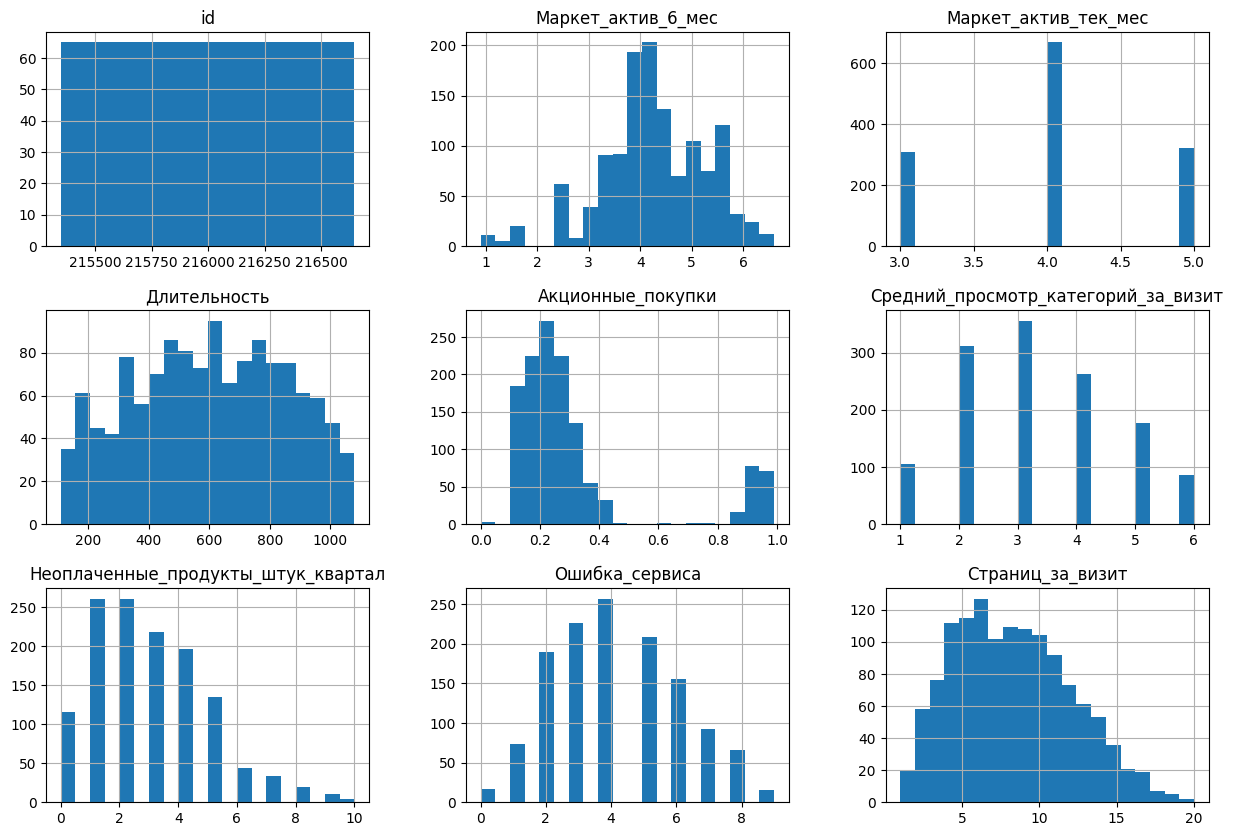

In [7]:
opening(data)

ПЕРВЫЕ ПЯТЬ СТРОК


,id,Период,Выручка
0,215348,препредыдущий_месяц,0.0
1,215348,текущий_месяц,3293.1
2,215348,предыдущий_месяц,0.0
3,215349,препредыдущий_месяц,4472.0
4,215349,текущий_месяц,4971.6


ИНФОРМАЦИЯ О ДАННЫХ
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3900 entries, 0 to 3899
Data columns (total 3 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   id       3900 non-null   int64  
 1   Период   3900 non-null   object 
 2   Выручка  3900 non-null   float64
dtypes: float64(1), int64(1), object(1)
memory usage: 91.5+ KB


КОЛИЧЕСТВО ПРОПУЩЕННЫХ ЗНАЧЕНИЙ
id         0
Период     0
Выручка    0
dtype: int64 

КОЛИЧЕСТВО ПРОПУЩЕННЫХ ЗНАЧЕНИЙ, %
id         0.0
Период     0.0
Выручка    0.0
dtype: float64 

ОПИСАНИЕ ЧИСЛОВЫХ ДАННЫХ
                  id        Выручка
count    3900.000000    3900.000000
mean   215997.500000    5025.696051
std       375.325686    1777.704104
min    215348.000000       0.000000
25%    215672.750000    4590.150000
50%    215997.500000    4957.500000
75%    216322.250000    5363.000000
max    216647.000000  106862.200000 

УНИКАЛЬНЫЕ ЗНАЧЕНИЯ КАТЕГОРИАЛЬНЫХ ДАННЫХ
Период: 3 уникальные значения - ['препредыд

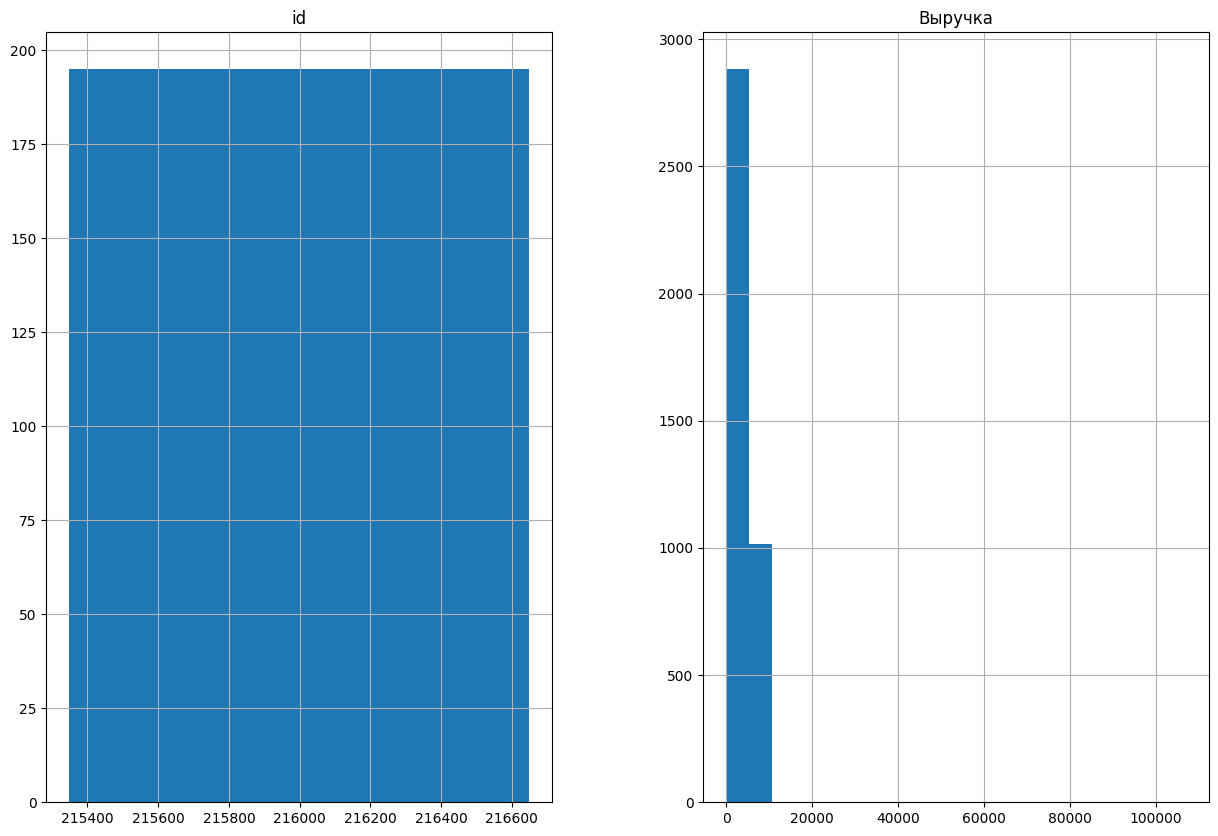

In [8]:
opening(data1)

ПЕРВЫЕ ПЯТЬ СТРОК


,id,Период,минут
0,215348,текущий_месяц,14
1,215348,предыдцщий_месяц,13
2,215349,текущий_месяц,10
3,215349,предыдцщий_месяц,12
4,215350,текущий_месяц,13


ИНФОРМАЦИЯ О ДАННЫХ
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2600 entries, 0 to 2599
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   id      2600 non-null   int64 
 1   Период  2600 non-null   object
 2   минут   2600 non-null   int64 
dtypes: int64(2), object(1)
memory usage: 61.1+ KB


КОЛИЧЕСТВО ПРОПУЩЕННЫХ ЗНАЧЕНИЙ
id        0
Период    0
минут     0
dtype: int64 

КОЛИЧЕСТВО ПРОПУЩЕННЫХ ЗНАЧЕНИЙ, %
id        0.0
Период    0.0
минут     0.0
dtype: float64 

ОПИСАНИЕ ЧИСЛОВЫХ ДАННЫХ
                  id        минут
count    2600.000000  2600.000000
mean   215997.500000    13.336154
std       375.349754     4.080198
min    215348.000000     4.000000
25%    215672.750000    10.000000
50%    215997.500000    13.000000
75%    216322.250000    16.000000
max    216647.000000    23.000000 

УНИКАЛЬНЫЕ ЗНАЧЕНИЯ КАТЕГОРИАЛЬНЫХ ДАННЫХ
Период: 2 уникальные значения - ['текущий_месяц' 'предыдцщий_месяц']


КОЛИЧЕСТВО ДУБЛИКА

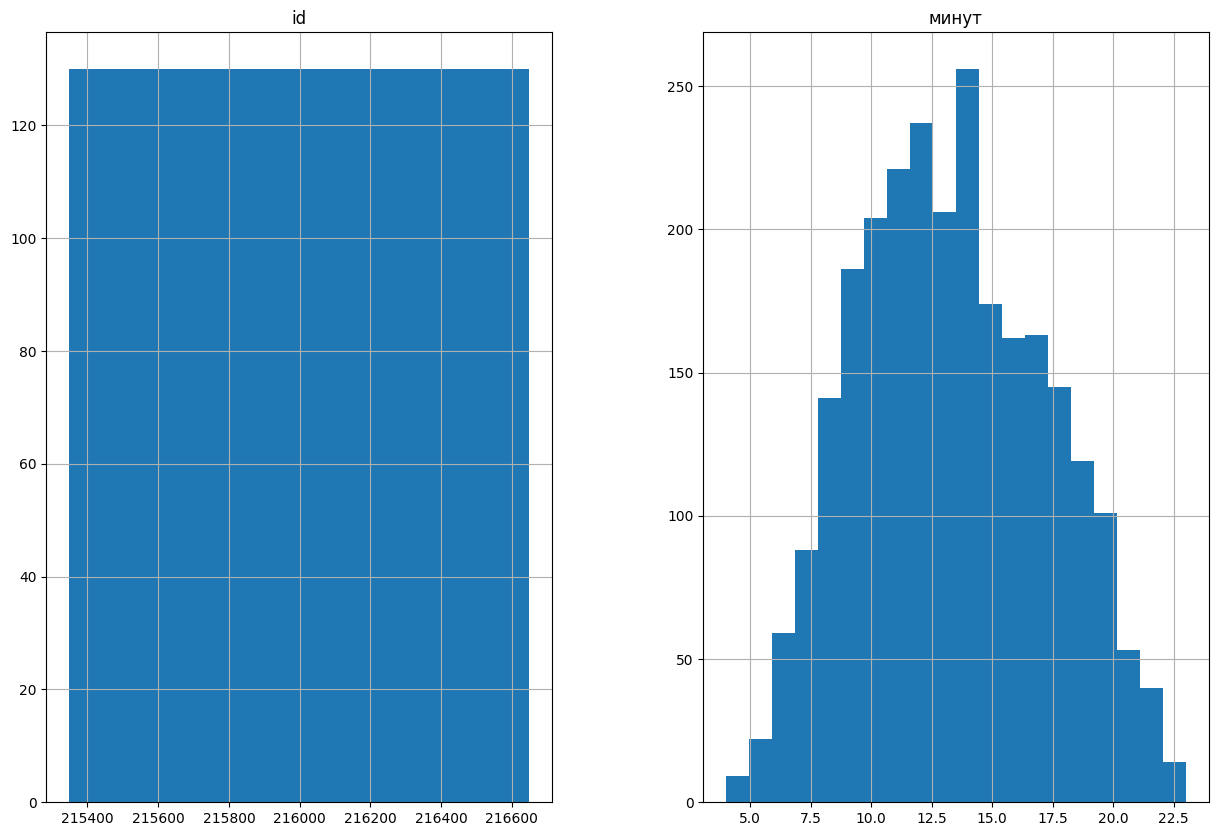

In [9]:
opening(data2)

ПЕРВЫЕ ПЯТЬ СТРОК


,id,Прибыль
0,215348,0.98
1,215349,4.16
2,215350,3.13
3,215351,4.87
4,215352,4.21


ИНФОРМАЦИЯ О ДАННЫХ
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1300 entries, 0 to 1299
Data columns (total 2 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   id       1300 non-null   int64  
 1   Прибыль  1300 non-null   float64
dtypes: float64(1), int64(1)
memory usage: 20.4 KB


КОЛИЧЕСТВО ПРОПУЩЕННЫХ ЗНАЧЕНИЙ
id         0
Прибыль    0
dtype: int64 

КОЛИЧЕСТВО ПРОПУЩЕННЫХ ЗНАЧЕНИЙ, %
id         0.0
Прибыль    0.0
dtype: float64 

ОПИСАНИЕ ЧИСЛОВЫХ ДАННЫХ
                  id      Прибыль
count    1300.000000  1300.000000
mean   215997.500000     3.996631
std       375.421985     1.013722
min    215348.000000     0.860000
25%    215672.750000     3.300000
50%    215997.500000     4.045000
75%    216322.250000     4.670000
max    216647.000000     7.430000 

УНИКАЛЬНЫЕ ЗНАЧЕНИЯ КАТЕГОРИАЛЬНЫХ ДАННЫХ


КОЛИЧЕСТВО ДУБЛИКАТОВ
0
РАСПРЕДЕЛЕНИЕ ДАННЫХ КОЛИЧЕСТВЕННЫХ СТОЛБЦОВ


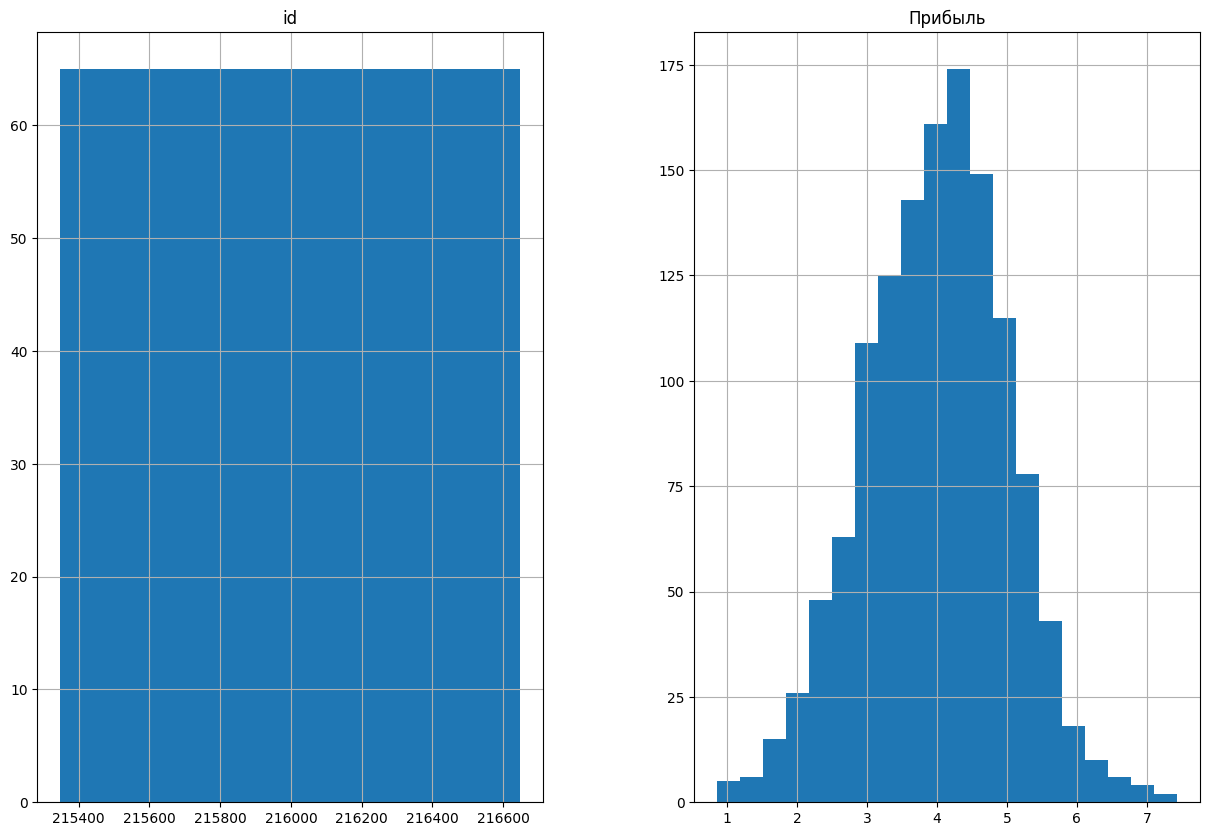

In [10]:
opening(data3)

**Вывод по разделу 1**:
У нас 4 таблицы с данными. Данные о поведении клиентов на сайте, времени (в минутах), которое покупатель провёл на сайте в течение периода. И о данных о выручке и прибыли компании.

1) Таблица 1300 строк, 13 столбцов, в каждой строке данные по каждому клиенту (id). Нет пропусков, нет дубликатов, есть неявные дубликаты, нужно будет всё привести к более удобному виду.  
2) 3900 строк и 3 столбца, данные по выручке от каждого клиента за 3 последних месяца, каждый на отдельной строке.  
3) 2600 строк и 3 столбца, данные  о времени (в минутах), которое покупатель провёл на сайте в течение периода.  
4) 1300 строк и 2 столбца, данные по прибыли

Везде необходимо провести предобрадотку данных для удобной работы, названия столбцов и данные внутри таблиц

<a id="предобработка"></a>  
# 2. Предобработка данных

В таблице 1 избавимся от неявных дубликатов, столбцы и строки приведем в удобный для работы вид. Изменим тип данных для id

ПЕРВЫЕ ПЯТЬ СТРОК


,id,покупательская_активность,тип_сервиса,разрешить_сообщать,маркет_актив_6_мес,маркет_актив_тек_мес,длительность,акционные_покупки,популярная_категория,средний_просмотр_категорий_за_визит,неоплаченные_продукты_штук_квартал,ошибка_сервиса,страниц_за_визит
0,215348,снизилась,премиум,да,3.4,5,121,0.00,товары_для_детей,6,2,1,5
1,215349,снизилась,премиум,да,4.4,4,819,0.75,товары_для_детей,4,4,2,5
2,215350,снизилась,стандарт,нет,4.9,3,539,0.14,домашний_текстиль,5,2,1,5
3,215351,снизилась,стандарт,да,3.2,5,896,0.99,товары_для_детей,5,0,6,4
4,215352,снизилась,стандарт,нет,5.1,3,1064,0.94,товары_для_детей,3,2,3,2


ИНФОРМАЦИЯ О ДАННЫХ
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1300 entries, 0 to 1299
Data columns (total 13 columns):
 #   Column                               Non-Null Count  Dtype  
---  ------                               --------------  -----  
 0   id                                   1300 non-null   object 
 1   покупательская_активность            1300 non-null   object 
 2   тип_сервиса                          1300 non-null   object 
 3   разрешить_сообщать                   1300 non-null   object 
 4   маркет_актив_6_мес                   1300 non-null   float64
 5   маркет_актив_тек_мес                 1300 non-null   int64  
 6   длительность                         1300 non-null   int64  
 7   акционные_покупки                    1300 non-null   float64
 8   популярная_категория                 1300 non-null   object 
 9   средний_просмотр_категорий_за_визит  1300 non-null   int64  
 10  неоплаченные_продукты_штук_квартал   1300 non-null   int64  
 11  ошибка_сер

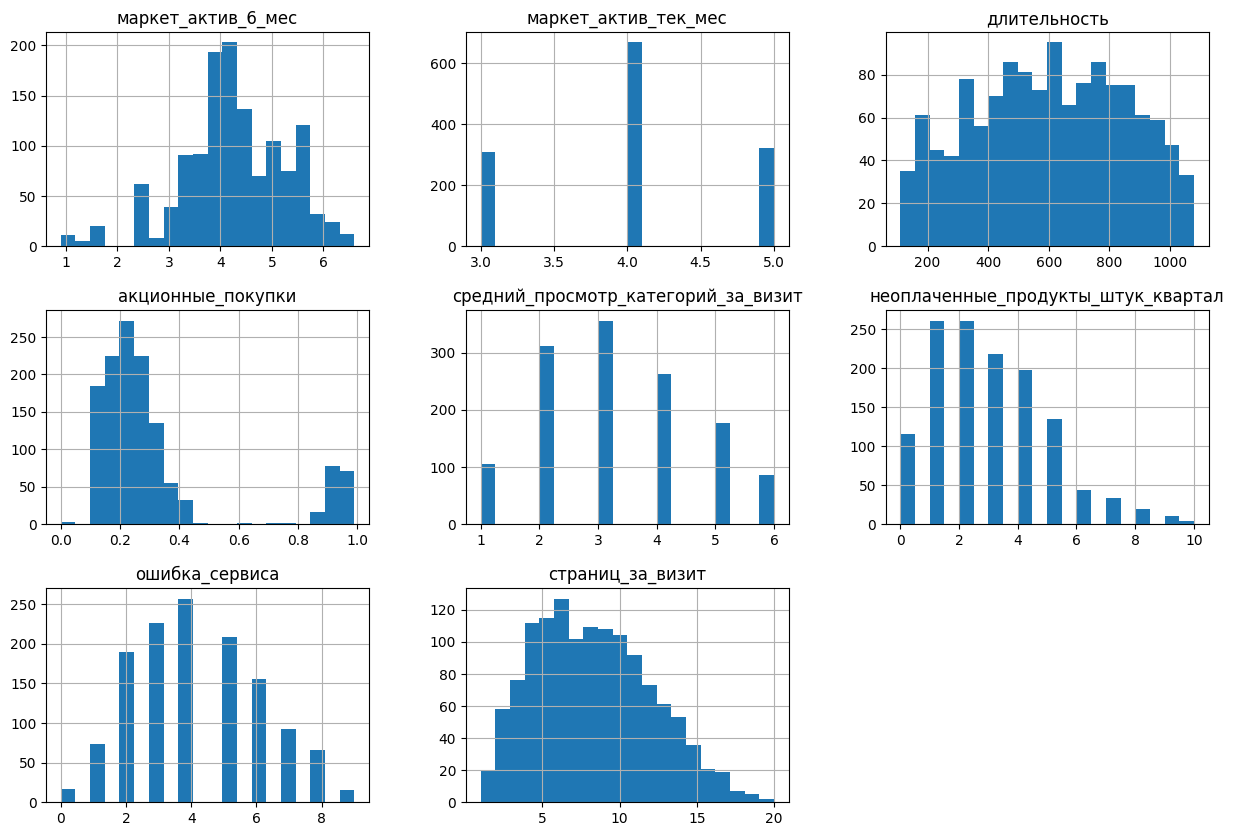

In [11]:
data.columns = data.columns.str.replace(' ', '_').str.lower()
data['тип_сервиса'] = data['тип_сервиса'].str.replace('стандартт', 'стандарт')
data['покупательская_активность'] = data['покупательская_активность'].str.replace(' ', '_').str.lower()
data['популярная_категория'] = data['популярная_категория'].str.replace(' ', '_').str.lower()
data['id'] = data['id'].astype('object')

opening(data)

В таблице два также изменим тип данных, приведем к нижнему решистру колонки

ПЕРВЫЕ ПЯТЬ СТРОК


,id,период,выручка
0,215348,препредыдущий_месяц,0.0
1,215348,текущий_месяц,3293.1
2,215348,предыдущий_месяц,0.0
3,215349,препредыдущий_месяц,4472.0
4,215349,текущий_месяц,4971.6


ИНФОРМАЦИЯ О ДАННЫХ
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3900 entries, 0 to 3899
Data columns (total 3 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   id       3900 non-null   object 
 1   период   3900 non-null   object 
 2   выручка  3900 non-null   float64
dtypes: float64(1), object(2)
memory usage: 91.5+ KB


КОЛИЧЕСТВО ПРОПУЩЕННЫХ ЗНАЧЕНИЙ
id         0
период     0
выручка    0
dtype: int64 

КОЛИЧЕСТВО ПРОПУЩЕННЫХ ЗНАЧЕНИЙ, %
id         0.0
период     0.0
выручка    0.0
dtype: float64 

ОПИСАНИЕ ЧИСЛОВЫХ ДАННЫХ
             выручка
count    3900.000000
mean     5025.696051
std      1777.704104
min         0.000000
25%      4590.150000
50%      4957.500000
75%      5363.000000
max    106862.200000 

УНИКАЛЬНЫЕ ЗНАЧЕНИЯ КАТЕГОРИАЛЬНЫХ ДАННЫХ
id: 1300 уникальные значения - [215348 215349 215350 ... 216645 216646 216647]
период: 3 уникальные значения - ['препредыдущий_месяц' 'текущий_месяц' 'предыдущий_месяц']


КОЛИЧЕСТВО ДУБЛИ

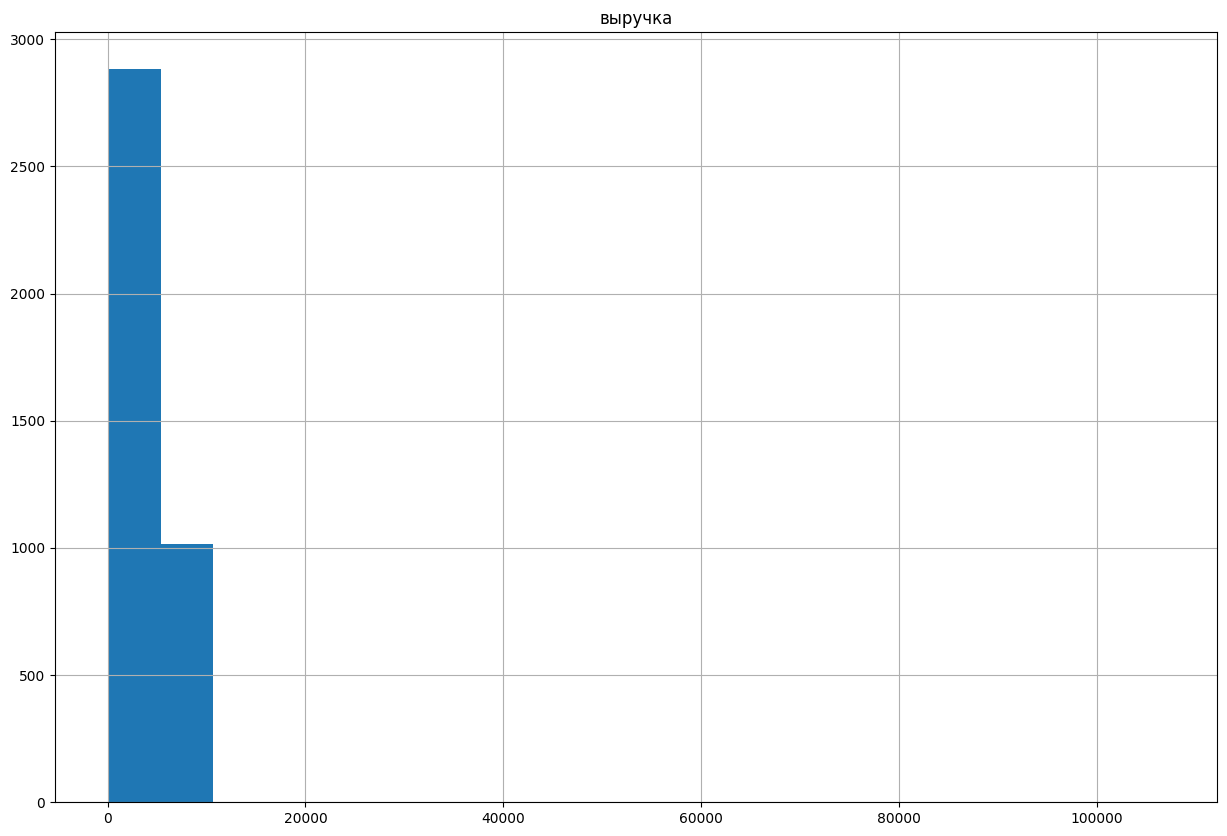

In [12]:
data1.columns = data1.columns.str.lower()
data1['id'] = data1['id'].astype('object')
opening(data1)

у нас есть явный выброс, заменим его на среднее значение данной колонки

In [13]:
data1.query('выручка > 10000') 

,id,период,выручка
98,215380,текущий_месяц,106862.2


In [14]:
data1_new = data1.copy()

data1_new.iloc[98, 2] = data1_new['выручка'].mean().round(2)
data1_new.iloc[98, :]

id                215380
период     текущий_месяц
выручка           5025.7
Name: 98, dtype: object

В таблице 3 продедаем те же операции для удобства и уберем неявные дубликаты

ПЕРВЫЕ ПЯТЬ СТРОК


,id,период,минут
0,215348,текущий_месяц,14
1,215348,предыдущий_месяц,13
2,215349,текущий_месяц,10
3,215349,предыдущий_месяц,12
4,215350,текущий_месяц,13


ИНФОРМАЦИЯ О ДАННЫХ
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2600 entries, 0 to 2599
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   id      2600 non-null   object
 1   период  2600 non-null   object
 2   минут   2600 non-null   int64 
dtypes: int64(1), object(2)
memory usage: 61.1+ KB


КОЛИЧЕСТВО ПРОПУЩЕННЫХ ЗНАЧЕНИЙ
id        0
период    0
минут     0
dtype: int64 

КОЛИЧЕСТВО ПРОПУЩЕННЫХ ЗНАЧЕНИЙ, %
id        0.0
период    0.0
минут     0.0
dtype: float64 

ОПИСАНИЕ ЧИСЛОВЫХ ДАННЫХ
             минут
count  2600.000000
mean     13.336154
std       4.080198
min       4.000000
25%      10.000000
50%      13.000000
75%      16.000000
max      23.000000 

УНИКАЛЬНЫЕ ЗНАЧЕНИЯ КАТЕГОРИАЛЬНЫХ ДАННЫХ
id: 1300 уникальные значения - [215348 215349 215350 ... 216645 216646 216647]
период: 2 уникальные значения - ['текущий_месяц' 'предыдущий_месяц']


КОЛИЧЕСТВО ДУБЛИКАТОВ
0
РАСПРЕДЕЛЕНИЕ ДАННЫХ КОЛИЧЕСТВЕННЫХ СТОЛБЦОВ


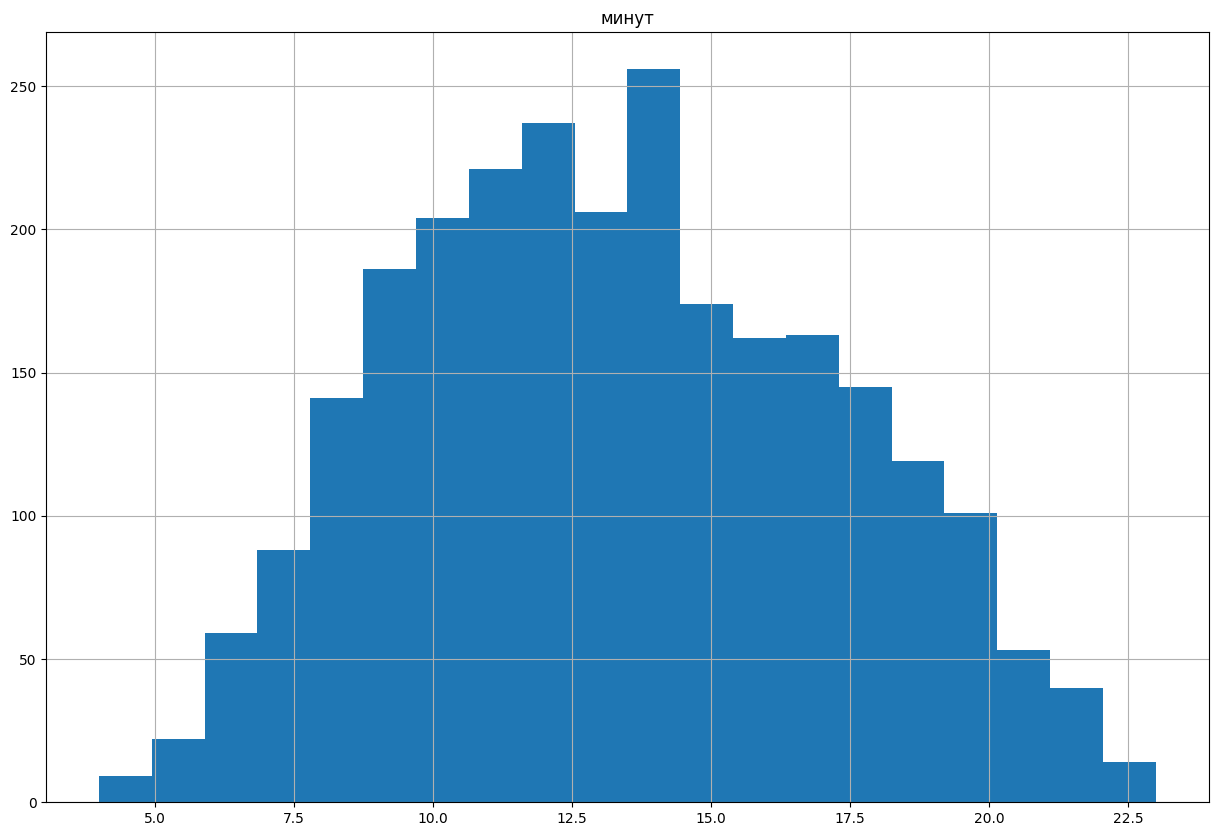

In [15]:
data2.columns = data2.columns.str.lower()
data2['период'] = data2['период'].str.replace('предыдцщий_месяц', 'предыдущий_месяц')
data2['id'] = data2['id'].astype('object')
opening(data2)

В таблице 4 еще нужно в столбце прибыль изменить тип данных на float, так как тут дробные числа. Так же нужно заменить запятую на точку

ПЕРВЫЕ ПЯТЬ СТРОК


,id,прибыль
0,215348,0.98
1,215349,4.16
2,215350,3.13
3,215351,4.87
4,215352,4.21


ИНФОРМАЦИЯ О ДАННЫХ
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1300 entries, 0 to 1299
Data columns (total 2 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   id       1300 non-null   object 
 1   прибыль  1300 non-null   float64
dtypes: float64(1), object(1)
memory usage: 20.4+ KB


КОЛИЧЕСТВО ПРОПУЩЕННЫХ ЗНАЧЕНИЙ
id         0
прибыль    0
dtype: int64 

КОЛИЧЕСТВО ПРОПУЩЕННЫХ ЗНАЧЕНИЙ, %
id         0.0
прибыль    0.0
dtype: float64 

ОПИСАНИЕ ЧИСЛОВЫХ ДАННЫХ
           прибыль
count  1300.000000
mean      3.996631
std       1.013722
min       0.860000
25%       3.300000
50%       4.045000
75%       4.670000
max       7.430000 

УНИКАЛЬНЫЕ ЗНАЧЕНИЯ КАТЕГОРИАЛЬНЫХ ДАННЫХ
id: 1300 уникальные значения - [215348 215349 215350 ... 216645 216646 216647]


КОЛИЧЕСТВО ДУБЛИКАТОВ
0
РАСПРЕДЕЛЕНИЕ ДАННЫХ КОЛИЧЕСТВЕННЫХ СТОЛБЦОВ


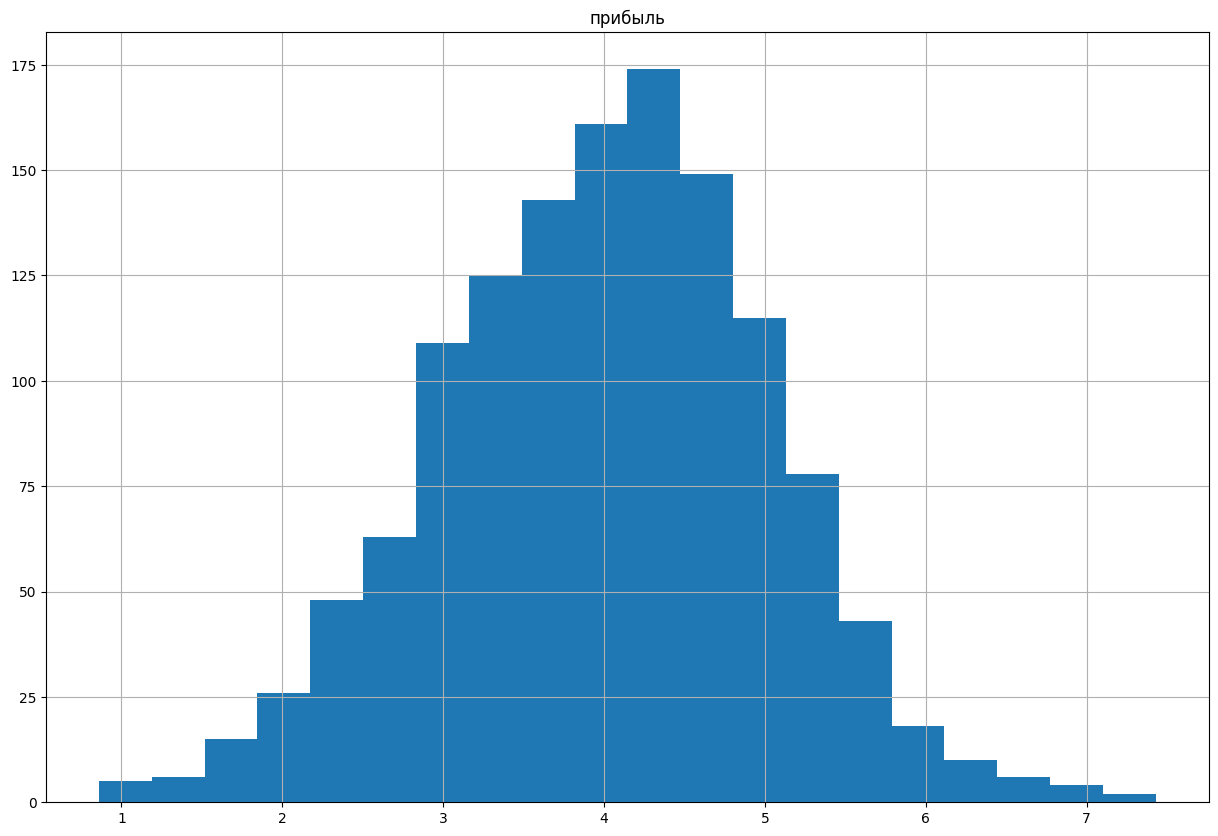

In [16]:
data3.columns = data3.columns.str.lower()
data3['прибыль'] = data3['прибыль'].astype('float')
data3['id'] = data3['id'].astype('object')
opening(data3)

**Итоги по разделу:**
1) Во всех 4 таблицах избавились от неявных дубликатов, столбцы id изменили на object (число тут не означает какую-то зависимость одного от другого, оно просто порядковое). Перевели везде столбцы и данные в таблицах в удобный нижний регистр, убрали пропуски.
2) Избавились от явного выброса в таблице с выручкой. Заменили на среднее по этому столбцу

<a id="исслед" ></a>
# 3. Исследовательский анализ данных

In [17]:
data.describe()

,маркет_актив_6_мес,маркет_актив_тек_мес,длительность,акционные_покупки,средний_просмотр_категорий_за_визит,неоплаченные_продукты_штук_квартал,ошибка_сервиса,страниц_за_визит
count,1300.000000,1300.000000,1300.000000,1300.000000,1300.00000,1300.000000,1300.000000,1300.000000
mean,4.253769,4.011538,601.898462,0.319808,3.27000,2.840000,4.185385,8.176923
std,1.014814,0.696868,249.856289,0.249843,1.35535,1.971451,1.955298,3.978126
min,0.900000,3.000000,110.000000,0.000000,1.00000,0.000000,0.000000,1.000000
25%,3.700000,4.000000,405.500000,0.170000,2.00000,1.000000,3.000000,5.000000
50%,4.200000,4.000000,606.000000,0.240000,3.00000,3.000000,4.000000,8.000000
75%,4.900000,4.000000,806.000000,0.300000,4.00000,4.000000,6.000000,11.000000
max,6.600000,5.000000,1079.000000,0.990000,6.00000,10.000000,9.000000,20.000000


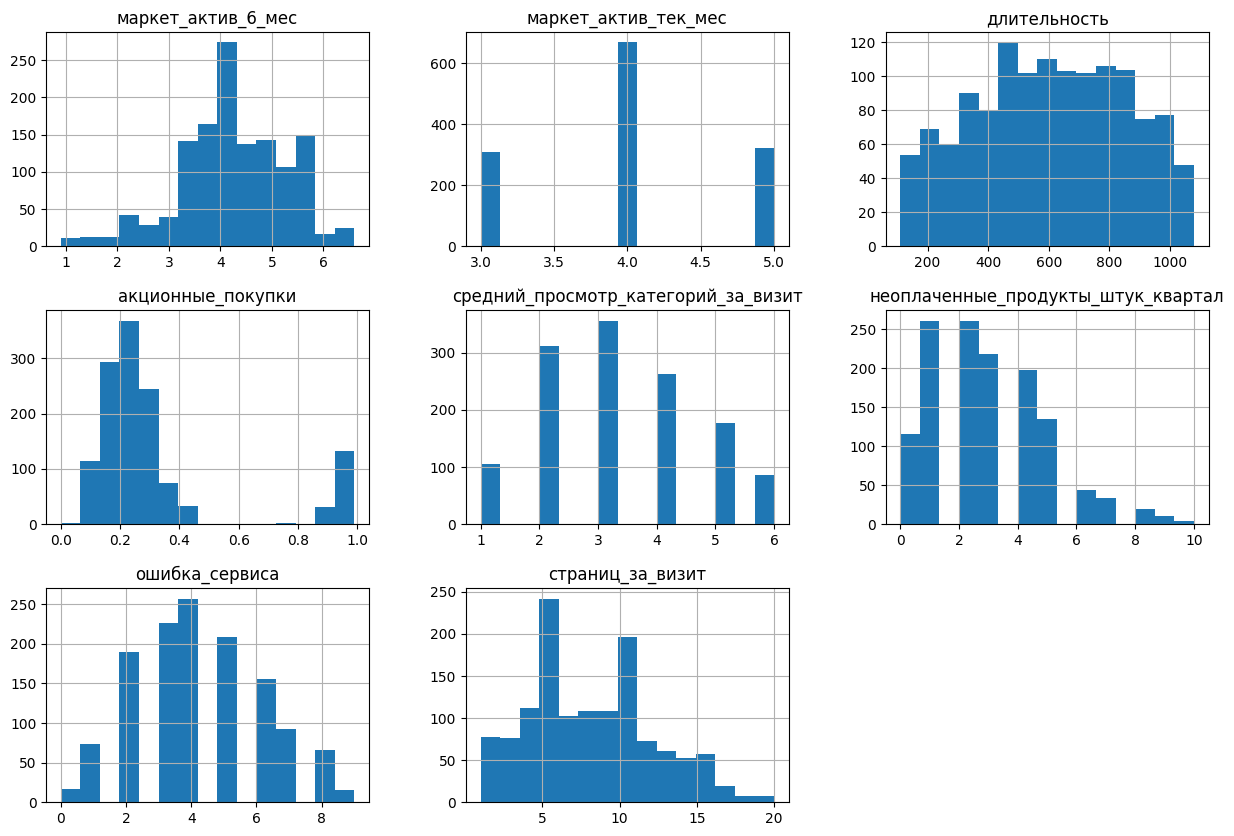

In [18]:
data.hist(figsize = (15,10), bins=15);

В первой таблице у нас 8 столбцов с количественными признаками. 'маркет_актив_6_мес', 'длительность' непрерывные, нормально распределены. В столбце 'акционные_покупки' есть две моды. Остальные 5 столбцов с дискретными признаками

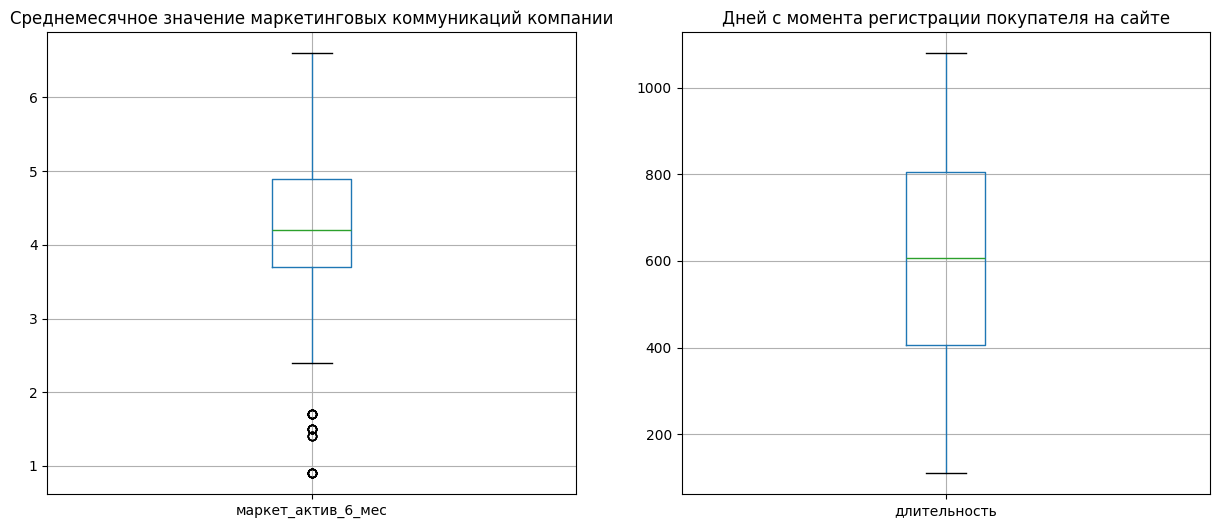

In [19]:
fig, axes = plt.subplots(1, 2, figsize=(15, 6))

data.boxplot(column='маркет_актив_6_мес', ax=axes[0])
axes[0].set_title('Cреднемесячное значение маркетинговых коммуникаций компании')

data.boxplot(column='длительность', ax=axes[1])
axes[1].set_title('Дней с момента регистрации покупателя на сайте');

Есть некоторые выбросы в "маркет_актив_6_мес", но они не сильно уходят отдаляются от обычных средних значений, выбросить их не  можем

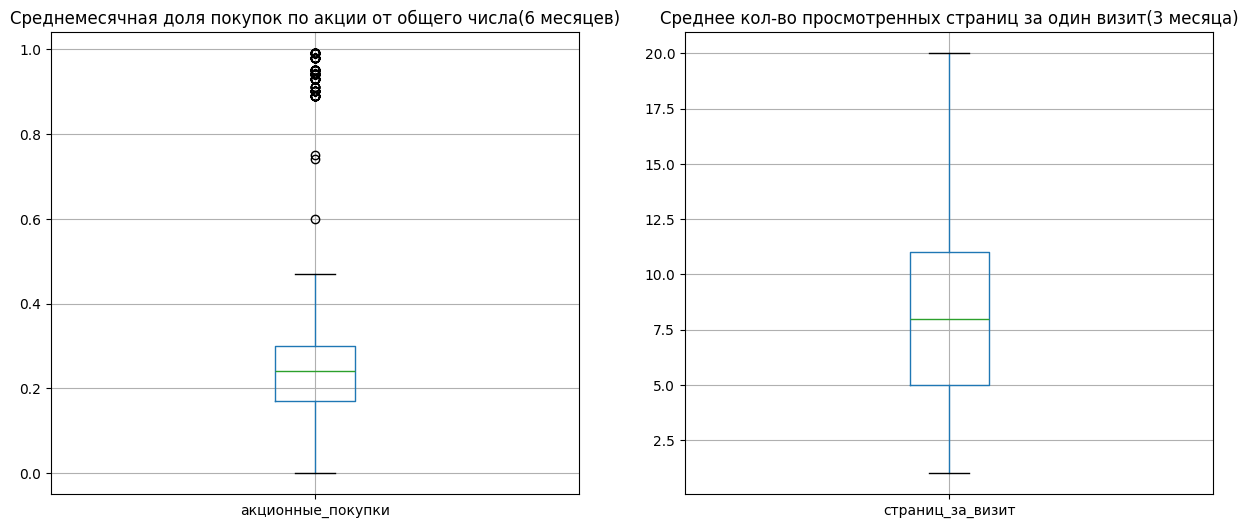

In [20]:
fig, axes = plt.subplots(1, 2, figsize=(15, 6))

data.boxplot(column='акционные_покупки', ax=axes[0])
axes[0].set_title('Среднемесячная доля покупок по акции от общего числа(6 месяцев)')

data.boxplot(column='страниц_за_визит', ax=axes[1])
axes[1].set_title('Среднее кол-во просмотренных страниц за один визит(3 месяца)');

По акционным покупкам тоже нельзя отбросить выбросы. Тут 2 моды - большинство людей всё же покупают не только акционные покупки, и их среднее где-то около 0.25. Но есть и много клиентов, которые покупают ТОЛЬКО акционные вещи, у них коэффициент стремится к 1. Все данные нужны для анализа

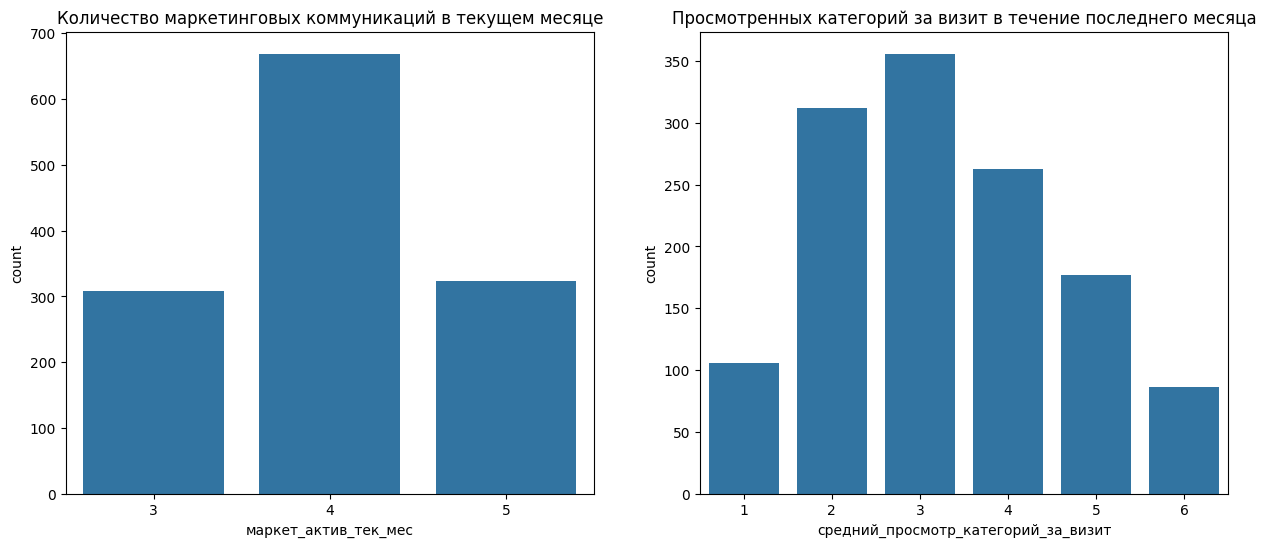

In [21]:
kat, axes = plt.subplots(1, 2, figsize=(15, 6))

sns.countplot(data=data, x='маркет_актив_тек_мес', ax=axes[0])
axes[0].set_title('Количество маркетинговых коммуникаций в текущем месяце')

sns.countplot(data=data, x='средний_просмотр_категорий_за_визит', ax=axes[1])
axes[1].set_title('Просмотренных категорий за визит в течение последнего месяца');

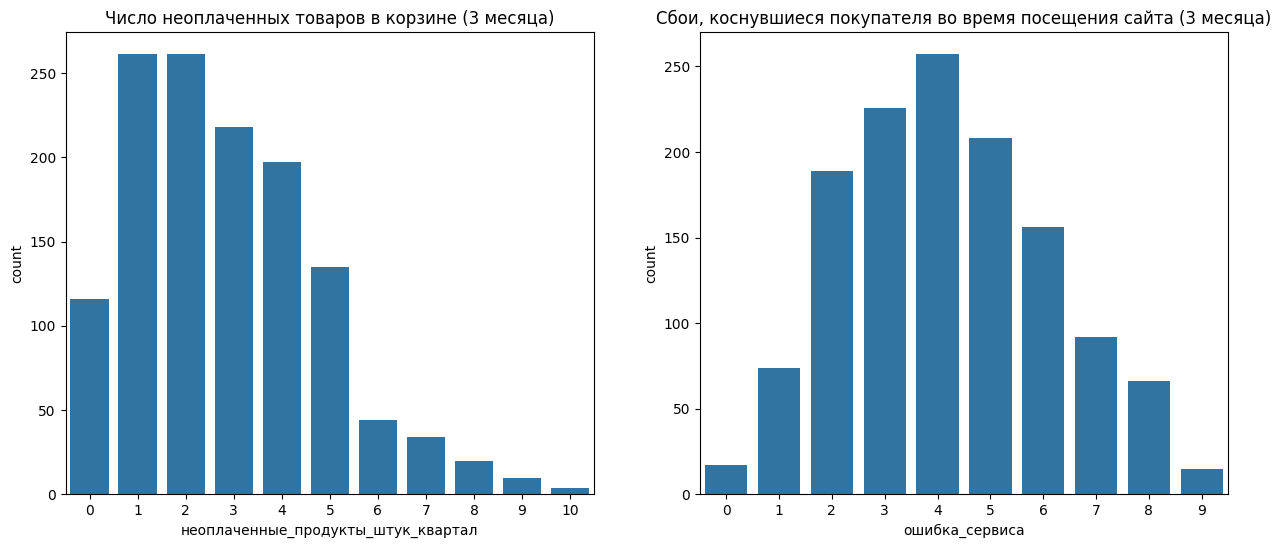

In [22]:
kat, axes = plt.subplots(1, 2, figsize=(15, 6))

sns.countplot(data=data, x='неоплаченные_продукты_штук_квартал', ax=axes[0])
axes[0].set_title('Число неоплаченных товаров в корзине (3 месяца)')

sns.countplot(data=data, x='ошибка_сервиса', ax=axes[1])
axes[1].set_title('Сбои, коснувшиеся покупателя во время посещения сайта (3 месяца)');

Теперь посмотрим на распределение категориальных переменных

In [23]:
data.describe(include = 'object')

,id,покупательская_активность,тип_сервиса,разрешить_сообщать,популярная_категория
count,1300,1300,1300,1300,1300
unique,1300,2,2,2,6
top,215348,прежний_уровень,стандарт,да,товары_для_детей
freq,1,802,924,962,330


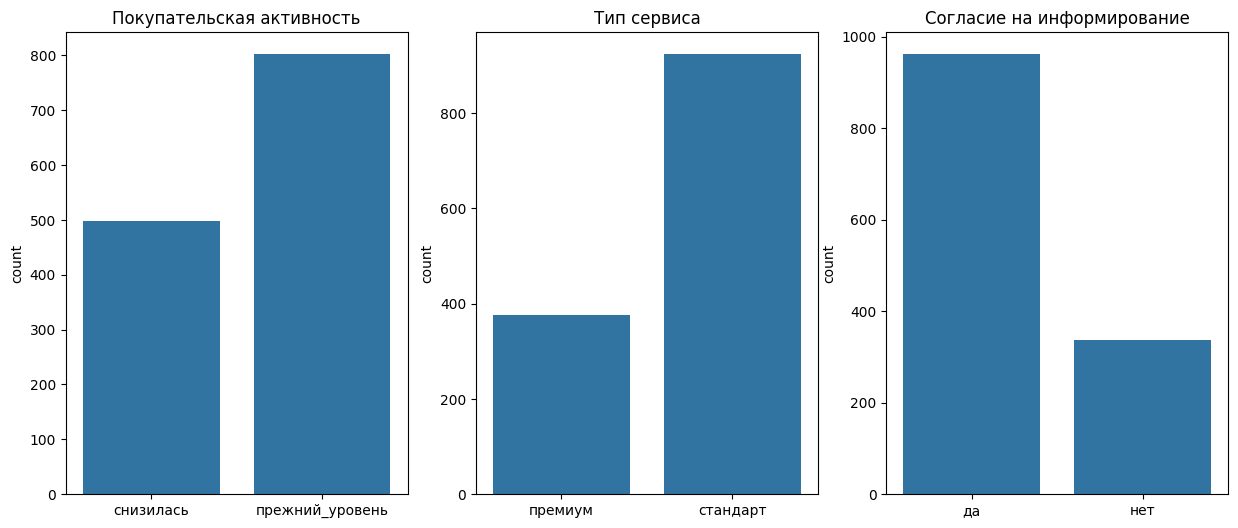

In [24]:
kat, axes = plt.subplots(1, 3, figsize=(15, 6))

sns.countplot(data=data, x='покупательская_активность', ax=axes[0])
axes[0].set_title('Покупательская активность')
axes[0].set_xlabel('')

sns.countplot(data=data, x='тип_сервиса', ax=axes[1])
axes[1].set_title('Тип сервиса')
axes[1].set_xlabel('')

sns.countplot(data=data, x='разрешить_сообщать', ax=axes[2])
axes[2].set_title('Согласие на информирование')
axes[2].set_xlabel('');

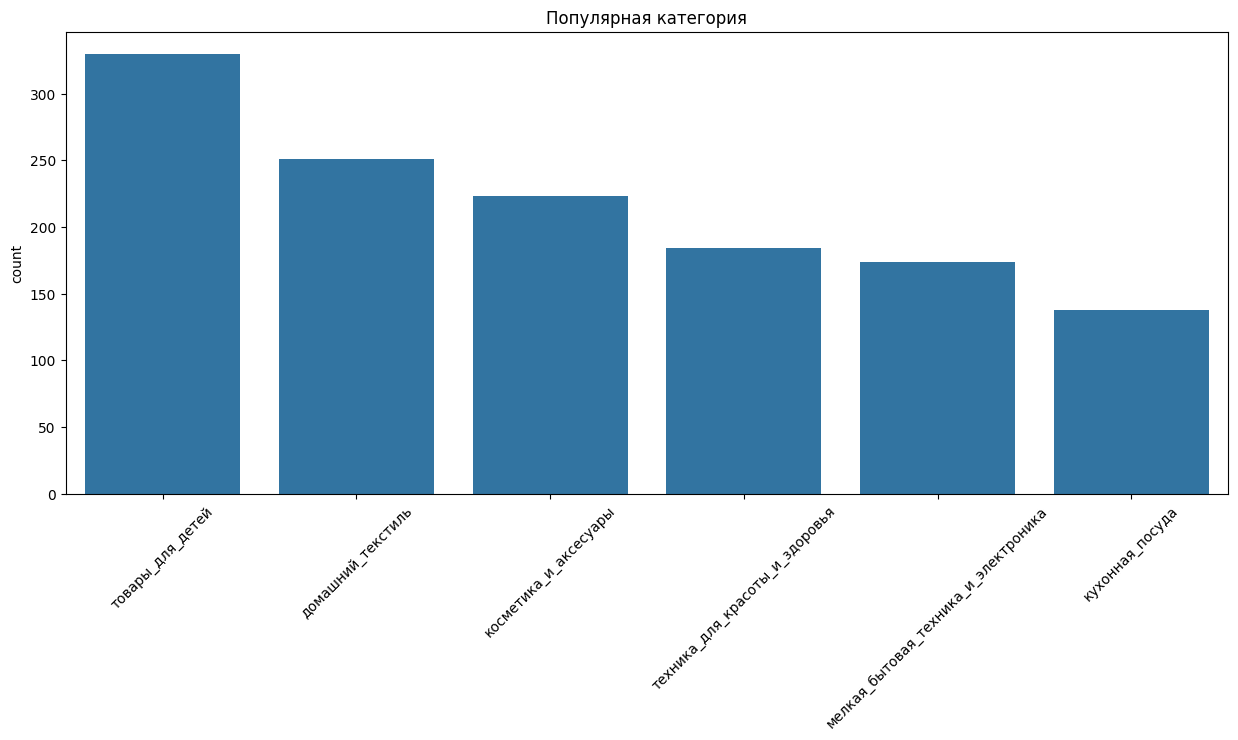

In [25]:
plt.figure(figsize=(15, 6))
ax = sns.countplot(data=data, x='популярная_категория', order = data['популярная_категория'].value_counts().index)
ax.set_title('Популярная категория')
ax.set_xlabel('')
plt.xticks(rotation=45);

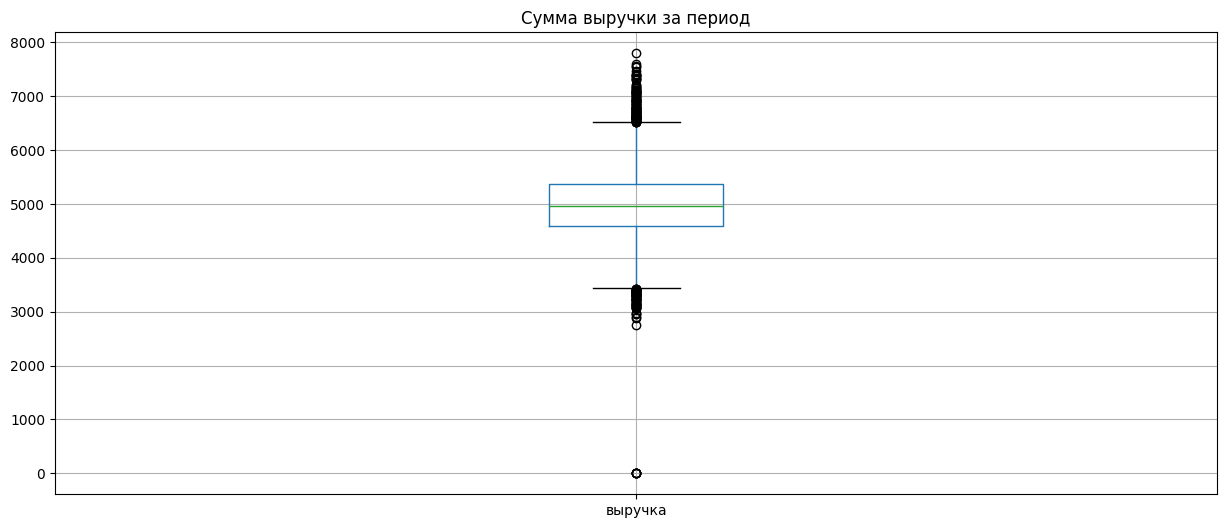

In [26]:
plt.figure(figsize=(15, 6))
ax = data1_new.boxplot(column='выручка')
ax.set_title('Сумма выручки за период');

После отсечения выброса мы видим, что за пределы усов уходит много данных по выручке от клиентов. Но разброс не критичный. А вот нули мы удалим из данных. По условиям задачи нам необходимо отобрать клиентов с покупательской активностью не менее трёх месяцев, то есть таких, которые что-либо покупали в этот период

In [27]:
df1 = data1_new.query('выручка == 0')['id'].values

data1_post = data1_new[~data1_new['id'].isin(df1)]
data1_post

,id,период,выручка
3,215349,препредыдущий_месяц,4472.0
4,215349,текущий_месяц,4971.6
5,215349,предыдущий_месяц,5216.0
6,215350,препредыдущий_месяц,4826.0
7,215350,текущий_месяц,5058.4
...,...,...,...
3895,216646,препредыдущий_месяц,4725.0
3896,216646,предыдущий_месяц,4923.0
3897,216647,предыдущий_месяц,4720.0
3898,216647,препредыдущий_месяц,5183.0


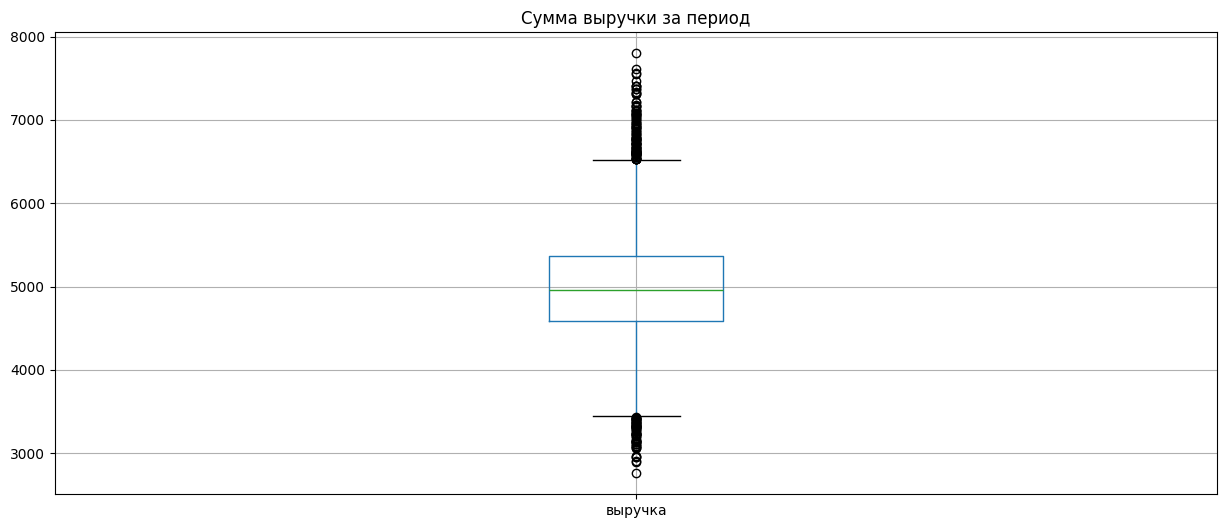

In [28]:
plt.figure(figsize=(15, 6))
ax = data1_post.boxplot(column='выручка')
ax.set_title('Сумма выручки за период');

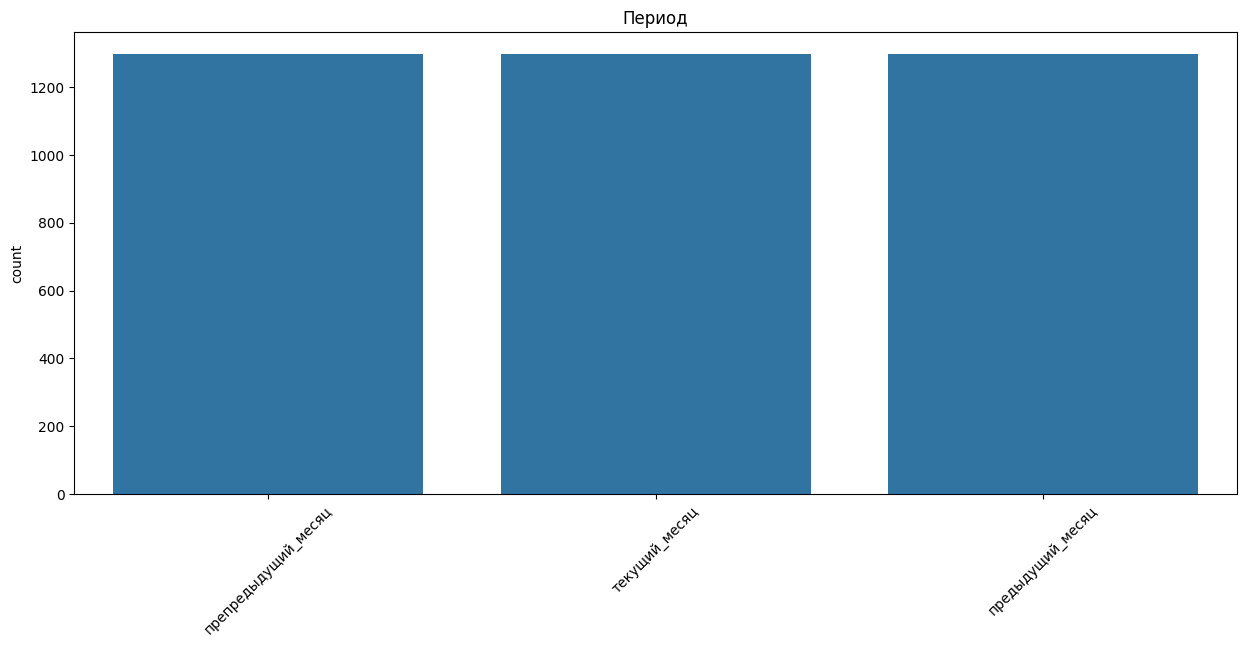

In [29]:
plt.figure(figsize=(15, 6))
ax = sns.countplot(data=data1_post, x='период')
ax.set_title('Период')
ax.set_xlabel('')
plt.xticks(rotation=45);

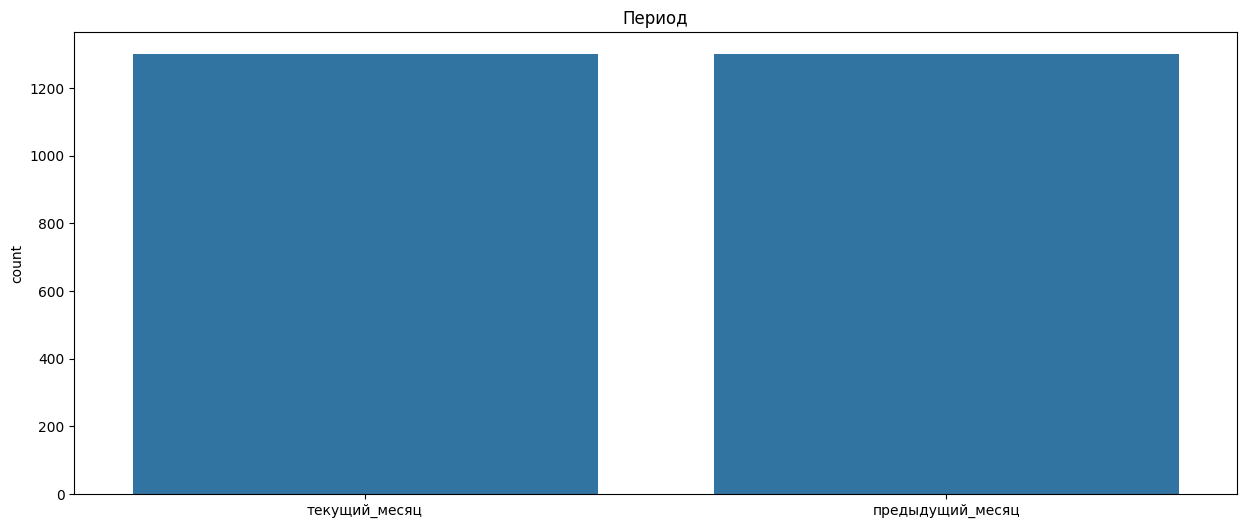

In [30]:
plt.figure(figsize=(15, 6))
ax = sns.countplot(data=data2, x='период')
ax.set_title('Период')
ax.set_xlabel('');

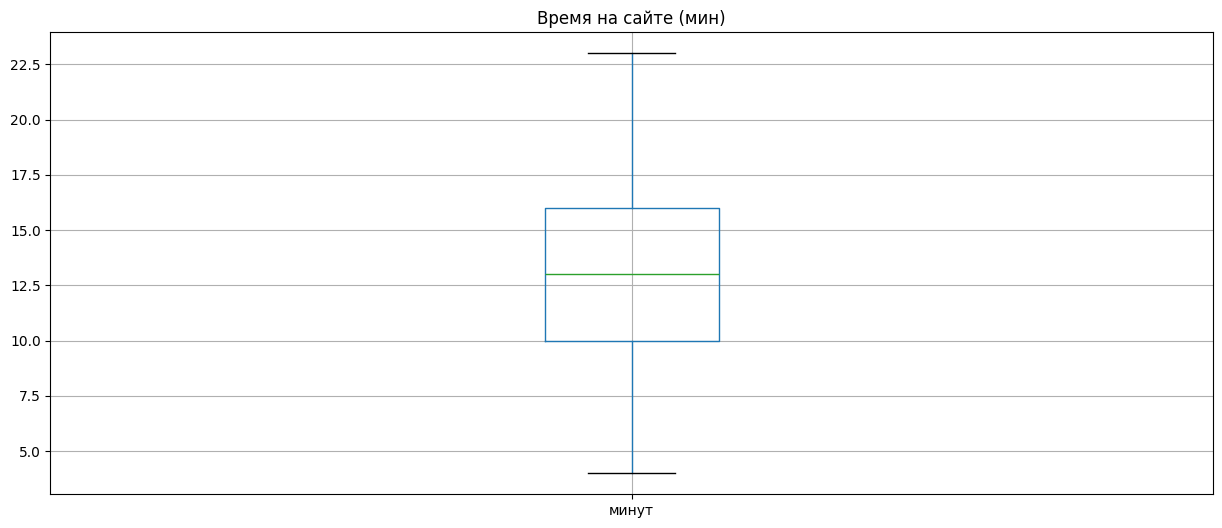

In [31]:
plt.figure(figsize=(15, 6))
ax = data2.boxplot(column='минут')
ax.set_title('Время на сайте (мин)');

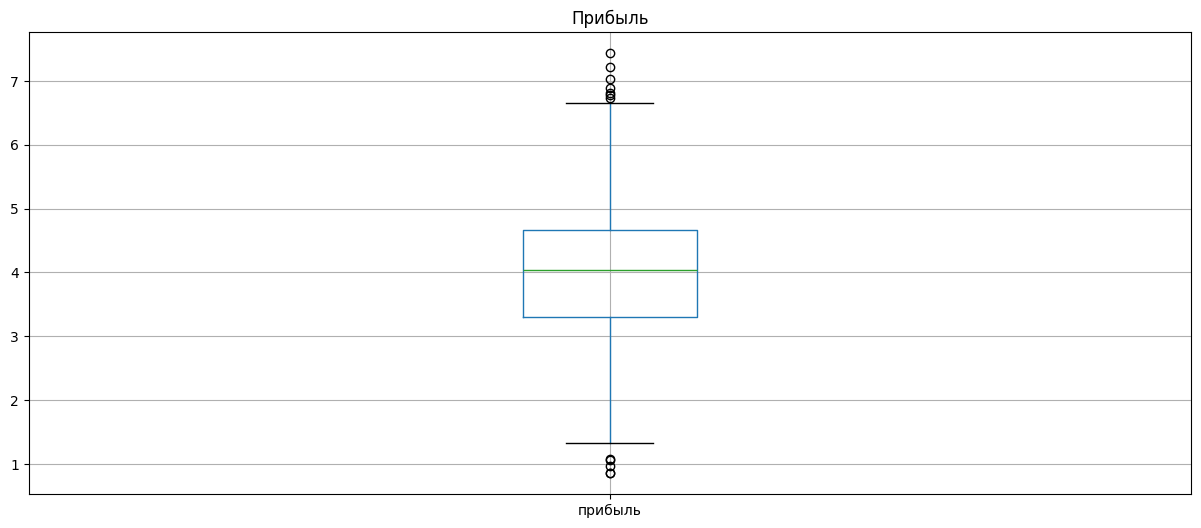

In [32]:
plt.figure(figsize=(15, 6))
ax = data3.boxplot(column='прибыль')
ax.set_title('Прибыль');

**Итог по разделу:**
1) Были исследованы датасеты на все признаки. Количественные и категориальные.
2) Есть данные с выбросами, однако эти выбросы не уходят далеко от "усов", и их признаки расположены с двух сторон, отбросить не можем, они важны для дальнейшего машинного обучения.
3) Есть выбросы в столбце "Выручка" (стоит 0), вот от них мы избавляемся.

<a id="таблицы"></a>
# 4.Объединение таблиц

In [33]:
data_pivot1 = data1_post.pivot_table(index = 'id', columns = 'период', values = 'выручка').reset_index()
data_pivot1.columns = data_pivot1.columns.str.replace('ц', 'ц_выручка')
data_pivot1

период,id,предыдущий_месяц_выручка,препредыдущий_месяц_выручка,текущий_месяц_выручка
0,215349,5216.0,4472.0,4971.6
1,215350,5457.5,4826.0,5058.4
2,215351,6158.0,4793.0,6610.4
3,215352,5807.5,4594.0,5872.5
4,215353,4738.5,5124.0,5388.5
...,...,...,...,...
1292,216643,3664.0,4704.0,4741.7
1293,216644,4729.0,5299.0,5353.0
1294,216645,5160.0,5334.0,5139.2
1295,216646,4923.0,4725.0,5224.6


In [34]:
data_pivot2 = data2.pivot_table(index='id', columns = 'период', values = 'минут').reset_index()
data_pivot2.columns = data_pivot2.columns.str.replace('ц', 'ц_минут')
data_pivot2

период,id,предыдущий_месяц_минут,текущий_месяц_минут
0,215348,13.0,14.0
1,215349,12.0,10.0
2,215350,8.0,13.0
3,215351,11.0,13.0
4,215352,8.0,11.0
...,...,...,...
1295,216643,14.0,7.0
1296,216644,12.0,11.0
1297,216645,12.0,18.0
1298,216646,18.0,7.0


In [35]:
data_new = data.merge(data_pivot1, on='id', how='inner')
data_new = data_new.merge(data_pivot2, on='id', how = 'inner')
data_new

,id,покупательская_активность,тип_сервиса,разрешить_сообщать,маркет_актив_6_мес,маркет_актив_тек_мес,длительность,акционные_покупки,популярная_категория,средний_просмотр_категорий_за_визит,неоплаченные_продукты_штук_квартал,ошибка_сервиса,страниц_за_визит,предыдущий_месяц_выручка,препредыдущий_месяц_выручка,текущий_месяц_выручка,предыдущий_месяц_минут,текущий_месяц_минут
0,215349,снизилась,премиум,да,4.4,4,819,0.75,товары_для_детей,4,4,2,5,5216.0,4472.0,4971.6,12.0,10.0
1,215350,снизилась,стандарт,нет,4.9,3,539,0.14,домашний_текстиль,5,2,1,5,5457.5,4826.0,5058.4,8.0,13.0
2,215351,снизилась,стандарт,да,3.2,5,896,0.99,товары_для_детей,5,0,6,4,6158.0,4793.0,6610.4,11.0,13.0
3,215352,снизилась,стандарт,нет,5.1,3,1064,0.94,товары_для_детей,3,2,3,2,5807.5,4594.0,5872.5,8.0,11.0
4,215353,снизилась,стандарт,да,3.3,4,762,0.26,домашний_текстиль,4,1,1,4,4738.5,5124.0,5388.5,10.0,10.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1292,216643,прежний_уровень,стандарт,да,6.6,3,318,0.24,техника_для_красоты_и_здоровья,5,3,3,11,3664.0,4704.0,4741.7,14.0,7.0
1293,216644,прежний_уровень,стандарт,нет,5.1,4,454,0.21,домашний_текстиль,6,2,3,9,4729.0,5299.0,5353.0,12.0,11.0
1294,216645,прежний_уровень,стандарт,да,4.1,3,586,0.20,домашний_текстиль,3,2,5,7,5160.0,5334.0,5139.2,12.0,18.0
1295,216646,прежний_уровень,стандарт,да,6.3,5,645,0.12,техника_для_красоты_и_здоровья,3,3,5,7,4923.0,4725.0,5224.6,18.0,7.0


**Итог по разделу:**
- Для объединения с таблицой data нам необходимо было развернуть таблицы data1 и data2, создав дополнительные столбцы. И потом необходимо объединить всё в одну. Так как у нас по условиям необходимо было удалить id, кто не был активен хотя бы раз в последние три месяца, мы совместили таблицы связью 'inner', оставив только те id,что нам нужны

<a id="корр"></a>  
# 5.Корреляционный анализ

In [36]:
data_new = data_new.set_index('id')

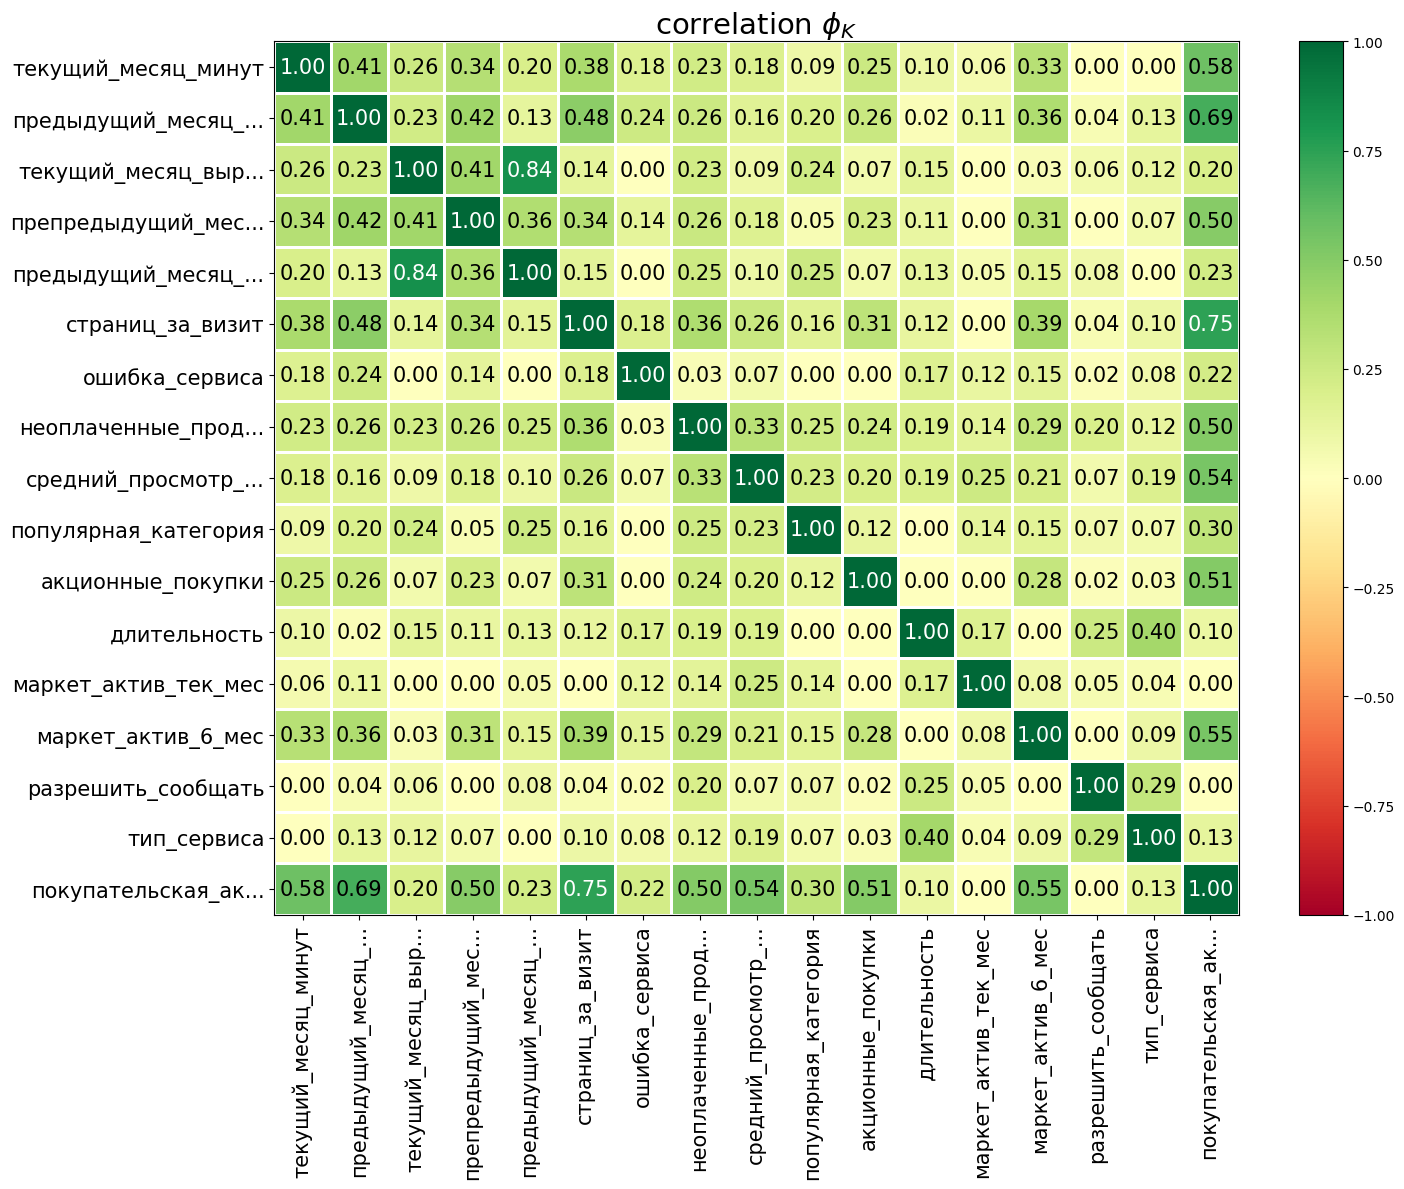

In [37]:
interval_cols = list(data_new.select_dtypes(include='number').columns)

phik_overview = data_new.phik_matrix(interval_cols=interval_cols)

plot_correlation_matrix(
    phik_overview.values,
    x_labels=phik_overview.columns,
    y_labels=phik_overview.index,
    title=r"correlation $\phi_K$",
    fontsize_factor=1.5,
    figsize=(15, 12)
)

По графику видим, что почти всё 0 или выше нуля - это значит, что всё положительно коррелирует друг с другом. Особенно высокая корреляция у покупательской активности

<a id="пайп"></a>  
# 6. Использование пайплайнов

Подготовим пайплайны. Для кодирования категориальных признаков используем как минимум два кодировщика (OneHotEncoder и OrdinalEncoder), для масштабирования количественных — как минимум два скейлера. MinMaxScaler, в другом StandardScaler. И 4 различные модели

In [38]:
data_new.head()

,покупательская_активность,тип_сервиса,разрешить_сообщать,маркет_актив_6_мес,маркет_актив_тек_мес,длительность,акционные_покупки,популярная_категория,средний_просмотр_категорий_за_визит,неоплаченные_продукты_штук_квартал,ошибка_сервиса,страниц_за_визит,предыдущий_месяц_выручка,препредыдущий_месяц_выручка,текущий_месяц_выручка,предыдущий_месяц_минут,текущий_месяц_минут
id,,,,,,,,,,,,,,,,,
215349,снизилась,премиум,да,4.4,4,819,0.75,товары_для_детей,4,4,2,5,5216.0,4472.0,4971.6,12.0,10.0
215350,снизилась,стандарт,нет,4.9,3,539,0.14,домашний_текстиль,5,2,1,5,5457.5,4826.0,5058.4,8.0,13.0
215351,снизилась,стандарт,да,3.2,5,896,0.99,товары_для_детей,5,0,6,4,6158.0,4793.0,6610.4,11.0,13.0
215352,снизилась,стандарт,нет,5.1,3,1064,0.94,товары_для_детей,3,2,3,2,5807.5,4594.0,5872.5,8.0,11.0
215353,снизилась,стандарт,да,3.3,4,762,0.26,домашний_текстиль,4,1,1,4,4738.5,5124.0,5388.5,10.0,10.0


In [39]:
X =  data_new.drop(['покупательская_активность'], axis=1)
y = data_new['покупательская_активность']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = TEST_SIZE, random_state = RANDOM_STATE,
    stratify = y)

label_encoder = LabelEncoder()
y_train = label_encoder.fit_transform(y_train)
y_test = label_encoder.transform(y_test)


ohe_columns = ['разрешить_сообщать', 'популярная_категория']
ord_columns = ['тип_сервиса']
num_columns = ['маркет_актив_6_мес', 'маркет_актив_тек_мес', 'длительность', 'акционные_покупки', 
               'средний_просмотр_категорий_за_визит', 'неоплаченные_продукты_штук_квартал', 'ошибка_сервиса',
              'страниц_за_визит', 'предыдущий_месяц_выручка', 'препредыдущий_месяц_выручка', 'текущий_месяц_выручка',
              'предыдущий_месяц_минут', 'текущий_месяц_минут']

In [40]:
ohe_pipe = Pipeline([
        ('simpleImputer_ohe', SimpleImputer(missing_values=np.nan, strategy='most_frequent')),
        ('ohe', OneHotEncoder(drop='first', handle_unknown='ignore', sparse_output=False))
    ])

ord_pipe = Pipeline([
        ('simpleImputer_before_ord', SimpleImputer(missing_values=np.nan, strategy='most_frequent')),
        ('ord', OrdinalEncoder(categories=[
                                            ['стандарт', 'премиум'],
                                          ], handle_unknown='use_encoded_value', unknown_value=np.nan)),
        ('simpleImputer_after_ord', 
            SimpleImputer(missing_values=np.nan, strategy='most_frequent'))    
    ])

data_preprocessor = ColumnTransformer(
    [
        ('ohe', ohe_pipe, ohe_columns),
        ('ord', ord_pipe, ord_columns),
        ('num', MinMaxScaler(), num_columns)
    ], 
    remainder='passthrough') 

pipe_final= Pipeline([
        ('preprocessor', data_preprocessor),
        ('models', DecisionTreeClassifier(random_state=RANDOM_STATE))
    ])

In [41]:
param_grid = [
     {
        'models': [DecisionTreeClassifier(random_state=RANDOM_STATE)],
         'models__max_depth': range(1, 5),
        'preprocessor__num': [StandardScaler(), MinMaxScaler(), 'passthrough']  
    },
     {
        'models': [KNeighborsClassifier()],
        'models__n_neighbors': range(1, 5),
        'preprocessor__num': [StandardScaler(), MinMaxScaler(), 'passthrough']   
    },
    {
        'models': [LogisticRegression(
            random_state=RANDOM_STATE, 
            solver='liblinear', 
            penalty='l1'
        )],
        'models__C': range(1, 5),
        'preprocessor__num': [StandardScaler(), MinMaxScaler()]  
    },
    {
        'models': [SVC(probability=True, random_state=RANDOM_STATE)],
        'models__C': range(1, 5),                      
        'preprocessor__num': [StandardScaler(), MinMaxScaler()] 
    }
]

In [42]:
data_new['покупательская_активность'].value_counts(normalize=True)

покупательская_активность
прежний_уровень    0.61835
снизилась          0.38165
Name: proportion, dtype: float64

Мы выбираем ROC-AUC, так как присутствует дисбаланс классов

In [43]:
gs = GridSearchCV(
    pipe_final,
    param_grid,
    n_jobs=-1,
    cv=3,
    scoring='roc_auc',
)

gs.fit(X_train, y_train)

,"estimator estimator: estimator objectThis is assumed to implement the scikit-learn estimator interface.Either estimator needs to provide a ``score`` function,or ``scoring`` must be passed.",Pipeline(step...m_state=42))])
,"param_grid param_grid: dict or list of dictionariesDictionary with parameters names (`str`) as keys and lists ofparameter settings to try as values, or a list of suchdictionaries, in which case the grids spanned by each dictionaryin the list are explored. This enables searching over any sequenceof parameter settings.","[{'models': [DecisionTreeC...ndom_state=42)], 'models__max_depth': range(1, 5), 'preprocessor__num': [StandardScaler(), MinMaxScaler(), ...]}, {'models': [KNeighborsClassifier()], 'models__n_neighbors': range(1, 5), 'preprocessor__num': [StandardScaler(), MinMaxScaler(), ...]}, ...]"
,"scoring scoring: str, callable, list, tuple or dict, default=NoneStrategy to evaluate the performance of the cross-validated model onthe test set.If `scoring` represents a single score, one can use:- a single string (see :ref:`scoring_string_names`);- a callable (see :ref:`scoring_callable`) that returns a single value;- `None`, the `estimator`'s :ref:`default evaluation criterion ` is used.If `scoring` represents multiple scores, one can use:- a list or tuple of unique strings;- a callable returning a dictionary where the keys are the metric names and the values are the metric scores;- a dictionary with metric names as keys and callables as values.See :ref:`multimetric_grid_search` for an example.",'roc_auc'
,"n_jobs n_jobs: int, default=NoneNumber of jobs to run in parallel.``None`` means 1 unless in a :obj:`joblib.parallel_backend` context.``-1`` means using all processors. See :term:`Glossary `for more details... versionchanged:: v0.20 `n_jobs` default changed from 1 to None",-1
,"refit refit: bool, str, or callable, default=TrueRefit an estimator using the best found parameters on the wholedataset.For multiple metric evaluation, this needs to be a `str` denoting thescorer that would be used to find the best parameters for refittingthe estimator at the end.Where there are considerations other than maximum score inchoosing a best estimator, ``refit`` can be set to a function whichreturns the selected ``best_index_`` given ``cv_results_``. In thatcase, the ``best_estimator_`` and ``best_params_`` will be setaccording to the returned ``best_index_`` while the ``best_score_``attribute will not be available.The refitted estimator is made available at the ``best_estimator_``attribute and permits using ``predict`` directly on this``GridSearchCV`` instance.Also for multiple metric evaluation, the attributes ``best_index_``,``best_score_`` and ``best_params_`` will only be available if``refit`` is set and all of them will be determined w.r.t this specificscorer.See ``scoring`` parameter to know more about multiple metricevaluation.See :ref:`sphx_glr_auto_examples_model_selection_plot_grid_search_digits.py`to see how to design a custom selection strategy using a callablevia `refit`.See :ref:`this example`for an example of how to use ``refit=callable`` to balance modelcomplexity and cross-validated score... versionchanged:: 0.20 Support for callable added.",True
,"cv cv: int, cross-validation generator or an iterable, default=NoneDetermines the cross-validation splitting strategy.Possible inputs for cv are:- None, to use the default 5-fold cross validation,- integer, to specify the number of folds in a `(Stratified)KFold`,- :term:`CV splitter`,- An iterable yielding (train, test) splits as arrays of indices.For integer/None inputs, if the estimator is a classifier and ``y`` iseither binary or multiclass, :class:`StratifiedKFold` is used. In allother cases, :class:`KFold` is used. These splitters are instantiatedwith `shuffle=False` so the splits will be the same across calls.Refer :ref:`User Guide ` for the variouscross-validation strategies that can be used here... versionchanged:: 0.22 ``cv`` default value if None 

In [44]:
print('Лучшая модель и её параметры:\n\n', gs.best_estimator_)
print ('Метрика лучшей модели на тренировочной выборке:', gs.best_score_)

y_test_pred = gs.predict_proba(X_test)[:,1]
print(f'Метрика ROC-AUC на тестовой выборке: {roc_auc_score(y_test, y_test_pred)}')

Лучшая модель и её параметры:

 Pipeline(steps=[('preprocessor',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('ohe',
                                                  Pipeline(steps=[('simpleImputer_ohe',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('ohe',
                                                                   OneHotEncoder(drop='first',
                                                                                 handle_unknown='ignore',
                                                                                 sparse_output=False))]),
                                                  ['разрешить_сообщать',
                                                   'популярная_категория']),
                                                 ('ord',
                                 

In [45]:
gs

,"estimator estimator: estimator objectThis is assumed to implement the scikit-learn estimator interface.Either estimator needs to provide a ``score`` function,or ``scoring`` must be passed.",Pipeline(step...m_state=42))])
,"param_grid param_grid: dict or list of dictionariesDictionary with parameters names (`str`) as keys and lists ofparameter settings to try as values, or a list of suchdictionaries, in which case the grids spanned by each dictionaryin the list are explored. This enables searching over any sequenceof parameter settings.","[{'models': [DecisionTreeC...ndom_state=42)], 'models__max_depth': range(1, 5), 'preprocessor__num': [StandardScaler(), MinMaxScaler(), ...]}, {'models': [KNeighborsClassifier()], 'models__n_neighbors': range(1, 5), 'preprocessor__num': [StandardScaler(), MinMaxScaler(), ...]}, ...]"
,"scoring scoring: str, callable, list, tuple or dict, default=NoneStrategy to evaluate the performance of the cross-validated model onthe test set.If `scoring` represents a single score, one can use:- a single string (see :ref:`scoring_string_names`);- a callable (see :ref:`scoring_callable`) that returns a single value;- `None`, the `estimator`'s :ref:`default evaluation criterion ` is used.If `scoring` represents multiple scores, one can use:- a list or tuple of unique strings;- a callable returning a dictionary where the keys are the metric names and the values are the metric scores;- a dictionary with metric names as keys and callables as values.See :ref:`multimetric_grid_search` for an example.",'roc_auc'
,"n_jobs n_jobs: int, default=NoneNumber of jobs to run in parallel.``None`` means 1 unless in a :obj:`joblib.parallel_backend` context.``-1`` means using all processors. See :term:`Glossary `for more details... versionchanged:: v0.20 `n_jobs` default changed from 1 to None",-1
,"refit refit: bool, str, or callable, default=TrueRefit an estimator using the best found parameters on the wholedataset.For multiple metric evaluation, this needs to be a `str` denoting thescorer that would be used to find the best parameters for refittingthe estimator at the end.Where there are considerations other than maximum score inchoosing a best estimator, ``refit`` can be set to a function whichreturns the selected ``best_index_`` given ``cv_results_``. In thatcase, the ``best_estimator_`` and ``best_params_`` will be setaccording to the returned ``best_index_`` while the ``best_score_``attribute will not be available.The refitted estimator is made available at the ``best_estimator_``attribute and permits using ``predict`` directly on this``GridSearchCV`` instance.Also for multiple metric evaluation, the attributes ``best_index_``,``best_score_`` and ``best_params_`` will only be available if``refit`` is set and all of them will be determined w.r.t this specificscorer.See ``scoring`` parameter to know more about multiple metricevaluation.See :ref:`sphx_glr_auto_examples_model_selection_plot_grid_search_digits.py`to see how to design a custom selection strategy using a callablevia `refit`.See :ref:`this example`for an example of how to use ``refit=callable`` to balance modelcomplexity and cross-validated score... versionchanged:: 0.20 Support for callable added.",True
,"cv cv: int, cross-validation generator or an iterable, default=NoneDetermines the cross-validation splitting strategy.Possible inputs for cv are:- None, to use the default 5-fold cross validation,- integer, to specify the number of folds in a `(Stratified)KFold`,- :term:`CV splitter`,- An iterable yielding (train, test) splits as arrays of indices.For integer/None inputs, if the estimator is a classifier and ``y`` iseither binary or multiclass, :class:`StratifiedKFold` is used. In allother cases, :class:`KFold` is used. These splitters are instantiatedwith `shuffle=False` so the splits will be the same across calls.Refer :ref:`User Guide ` for the variouscross-validation strategies that can be used here... versionchanged:: 0.22 ``cv`` default value if None 

In [46]:
gs.best_params_

{'models': SVC(probability=True, random_state=42),
 'models__C': 1,
 'preprocessor__num': StandardScaler()}

In [47]:
pd.DataFrame(gs.cv_results_)[['rank_test_score', 'mean_test_score','params']].sort_values(by='rank_test_score').head(10)

,rank_test_score,mean_test_score,params
32,1,0.910943,"{'models': SVC(probability=True, random_state=42), 'models__C': 1, 'preprocessor__num': Standard..."
34,2,0.908013,"{'models': SVC(probability=True, random_state=42), 'models__C': 2, 'preprocessor__num': Standard..."
36,3,0.906051,"{'models': SVC(probability=True, random_state=42), 'models__C': 3, 'preprocessor__num': Standard..."
38,4,0.904545,"{'models': SVC(probability=True, random_state=42), 'models__C': 4, 'preprocessor__num': Standard..."
33,5,0.899092,"{'models': SVC(probability=True, random_state=42), 'models__C': 1, 'preprocessor__num': MinMaxSc..."
37,6,0.898790,"{'models': SVC(probability=True, random_state=42), 'models__C': 3, 'preprocessor__num': MinMaxSc..."
35,7,0.898530,"{'models': SVC(probability=True, random_state=42), 'models__C': 2, 'preprocessor__num': MinMaxSc..."
25,8,0.897849,"{'models': LogisticRegression(penalty='l1', random_state=42, solver='liblinear'), 'models__C': 1..."
27,9,0.897715,"{'models': LogisticRegression(penalty='l1', random_state=42, solver='liblinear'), 'models__C': 2..."
24,10,0.897110,"{'models': LogisticRegression(penalty='l1', random_state=42, solver='liblinear'), 'models__C': 1..."


**Итоги по разделу:**\
По итогам обучения четырех моделей лучшей показала себя SVC(probability=True, C=1, StandardScaler)  
Метрика лучшей модели на тренировочной выборке: 0.0.911  
Метрика ROC-AUC на тестовой выборке: 0.918

<a id="признаки"></a>  
# 7. Анализ важности признаков

In [48]:
best_pipe = gs.best_estimator_

best_preprocessor = best_pipe.named_steps['preprocessor']

best_model = best_pipe.named_steps['models']

PermutationExplainer explainer: 101it [01:46,  1.11s/it]                                                               


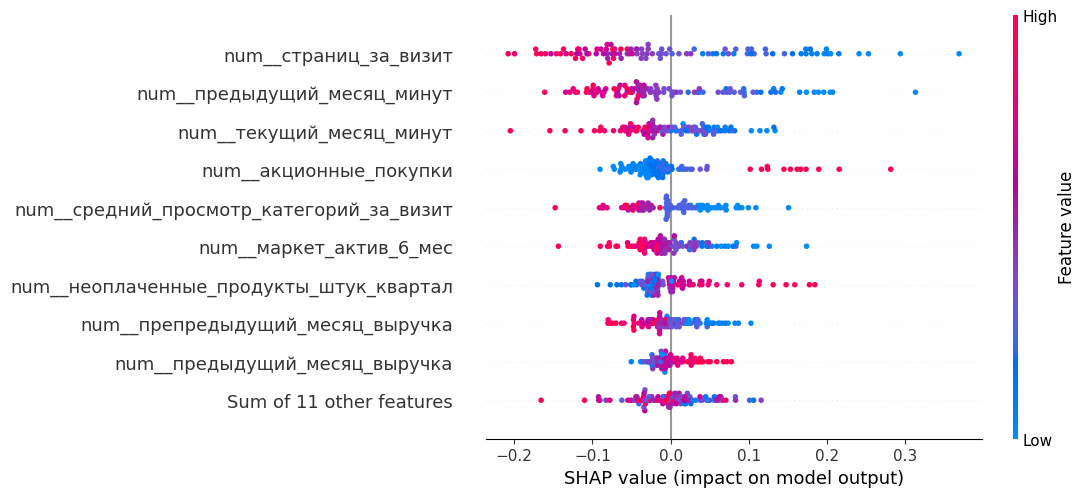

In [49]:
X_ready = best_preprocessor.transform(X)
X_ready_df = pd.DataFrame(X_ready, columns=best_preprocessor.get_feature_names_out())

best_model.fit(X_ready_df, y)

feature_names = best_preprocessor.get_feature_names_out()

X_sample = shap.utils.sample(X_ready_df, 100, random_state=42)
X_sample_df = pd.DataFrame(X_sample, columns = feature_names)

model_fn = lambda X: best_model.predict_proba(X)[:, 1]
explainer = shap.Explainer(model_fn, X_sample_df)
shap_values = explainer(X_sample_df)

shap.plots.beeswarm(shap_values)

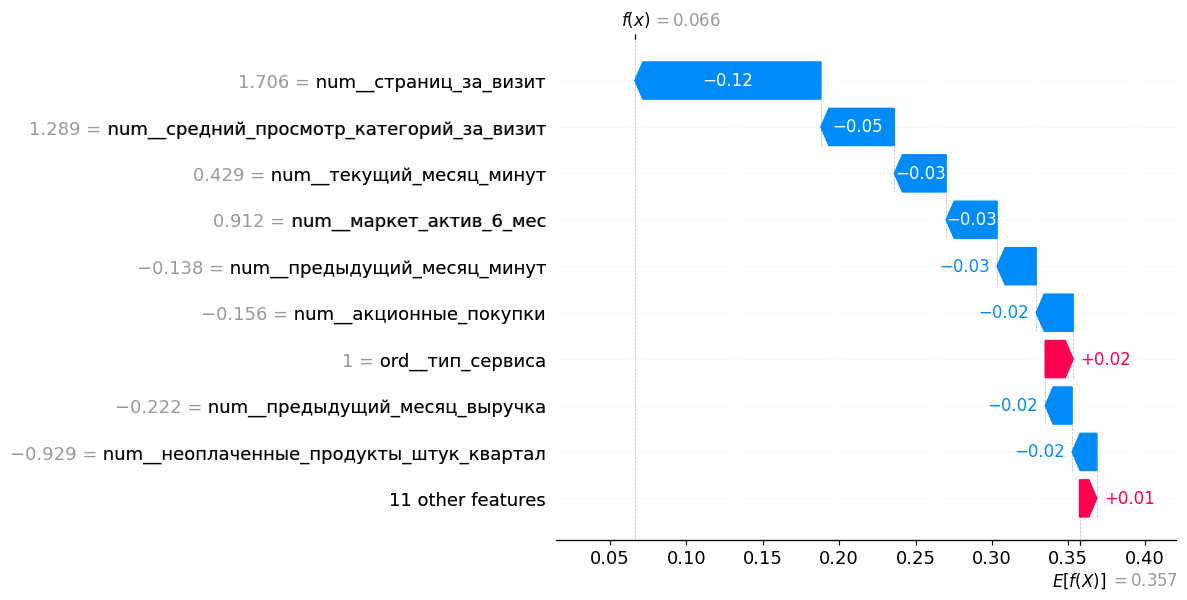

In [50]:
shap.plots.waterfall(shap_values[4])

**Итоговые выводы по разделу:**
1) Важность признаков на графике SHAP считается сверху вниз. И мы видим, что самые важные признаки влияния на предсказания модели это количество страниц за визит, предыдущий месяц минут и текущий месяц минут.
2) Самых малозначимых признаков на влияние предсказания модели 11 штук. К примеру, популярная_категория - косметика_и_аксесуары или текущий месяц выручка.
3) Благодаря данным SHAP мы можем увидеть, какие признаки важны для предсказания модели. Какие признаки можно даже исключить или не слишком принимать в расчет. Можно сегментировать покупателей.

<a id="сегм"></a>  
# 8. Сегментация покупателей

In [51]:
y_test_profit =data_new.merge(data3, on='id')
y_test_profit['покупательская_активность'] = (
    y_test_profit['покупательская_активность'].apply(lambda x: 1 if x == 'снизилась' else 0)
)
y_test_profit

,id,покупательская_активность,тип_сервиса,разрешить_сообщать,маркет_актив_6_мес,маркет_актив_тек_мес,длительность,акционные_покупки,популярная_категория,средний_просмотр_категорий_за_визит,неоплаченные_продукты_штук_квартал,ошибка_сервиса,страниц_за_визит,предыдущий_месяц_выручка,препредыдущий_месяц_выручка,текущий_месяц_выручка,предыдущий_месяц_минут,текущий_месяц_минут,прибыль
0,215349,1,премиум,да,4.4,4,819,0.75,товары_для_детей,4,4,2,5,5216.0,4472.0,4971.6,12.0,10.0,4.16
1,215350,1,стандарт,нет,4.9,3,539,0.14,домашний_текстиль,5,2,1,5,5457.5,4826.0,5058.4,8.0,13.0,3.13
2,215351,1,стандарт,да,3.2,5,896,0.99,товары_для_детей,5,0,6,4,6158.0,4793.0,6610.4,11.0,13.0,4.87
3,215352,1,стандарт,нет,5.1,3,1064,0.94,товары_для_детей,3,2,3,2,5807.5,4594.0,5872.5,8.0,11.0,4.21
4,215353,1,стандарт,да,3.3,4,762,0.26,домашний_текстиль,4,1,1,4,4738.5,5124.0,5388.5,10.0,10.0,3.95
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1292,216643,0,стандарт,да,6.6,3,318,0.24,техника_для_красоты_и_здоровья,5,3,3,11,3664.0,4704.0,4741.7,14.0,7.0,4.44
1293,216644,0,стандарт,нет,5.1,4,454,0.21,домашний_текстиль,6,2,3,9,4729.0,5299.0,5353.0,12.0,11.0,6.11
1294,216645,0,стандарт,да,4.1,3,586,0.20,домашний_текстиль,3,2,5,7,5160.0,5334.0,5139.2,12.0,18.0,3.29
1295,216646,0,стандарт,да,6.3,5,645,0.12,техника_для_красоты_и_здоровья,3,3,5,7,4923.0,4725.0,5224.6,18.0,7.0,4.03


In [52]:
profit_mean = y_test_profit['прибыль'].mean()
profit_mean

3.9976098689282957

Создадим функцию, чтобы сегментировать наших покупателей. 4 группы:
1) Остающийся, прибыльный.
2) Уходящий, прибыльный.
3) Остающийся, мало денег.
4) Уходящий, мало денег.

За линию разделения вероятности берем y_test_pred = 0.5, а за прибыль - среднее от всех тестовых

In [53]:
def segment(row):
    if row['покупательская_активность'] <= 0.5 and row['прибыль'] > profit_mean:
        return 'Остающийся, прибыльный'
    elif row['покупательская_активность'] > 0.5 and row['прибыль'] > profit_mean:
        return 'Уходящий, прибыльный'
    elif row['покупательская_активность'] <= 0.5 and row['прибыль'] <= profit_mean:
        return 'Остающийся, мало денег'
    else:
        return 'Уходящий, мало денег'

In [54]:
y_test_profit['сегмент'] = y_test_profit.apply(segment, axis=1)
y_test_profit.head()

,id,покупательская_активность,тип_сервиса,разрешить_сообщать,маркет_актив_6_мес,маркет_актив_тек_мес,длительность,акционные_покупки,популярная_категория,средний_просмотр_категорий_за_визит,неоплаченные_продукты_штук_квартал,ошибка_сервиса,страниц_за_визит,предыдущий_месяц_выручка,препредыдущий_месяц_выручка,текущий_месяц_выручка,предыдущий_месяц_минут,текущий_месяц_минут,прибыль,сегмент
0,215349,1,премиум,да,4.4,4,819,0.75,товары_для_детей,4,4,2,5,5216.0,4472.0,4971.6,12.0,10.0,4.16,"Уходящий, прибыльный"
1,215350,1,стандарт,нет,4.9,3,539,0.14,домашний_текстиль,5,2,1,5,5457.5,4826.0,5058.4,8.0,13.0,3.13,"Уходящий, мало денег"
2,215351,1,стандарт,да,3.2,5,896,0.99,товары_для_детей,5,0,6,4,6158.0,4793.0,6610.4,11.0,13.0,4.87,"Уходящий, прибыльный"
3,215352,1,стандарт,нет,5.1,3,1064,0.94,товары_для_детей,3,2,3,2,5807.5,4594.0,5872.5,8.0,11.0,4.21,"Уходящий, прибыльный"
4,215353,1,стандарт,да,3.3,4,762,0.26,домашний_текстиль,4,1,1,4,4738.5,5124.0,5388.5,10.0,10.0,3.95,"Уходящий, мало денег"


Важной группой для нас будут клиенты, которые относятся к группе, приносящих много денег, но чья активность снизилась (Уходящий, прибыльный)

In [55]:
y_test_profit.groupby('сегмент')['прибыль'].agg(['mean', 'count']).round(2)

,mean,count
сегмент,,
"Остающийся, мало денег",3.15,390
"Остающийся, прибыльный",4.80,412
"Уходящий, мало денег",3.18,236
"Уходящий, прибыльный",4.74,259


In [56]:
y_test_profit.groupby('сегмент')['разрешить_сообщать'].value_counts(normalize=True)

сегмент                 разрешить_сообщать
Остающийся, мало денег  да                    0.733333
                        нет                   0.266667
Остающийся, прибыльный  да                    0.740291
                        нет                   0.259709
Уходящий, мало денег    да                    0.745763
                        нет                   0.254237
Уходящий, прибыльный    да                    0.741313
                        нет                   0.258687
Name: proportion, dtype: float64

In [57]:
y_test_profit.groupby('сегмент')['тип_сервиса'].value_counts(normalize=True)

сегмент                 тип_сервиса
Остающийся, мало денег  стандарт       0.756410
                        премиум        0.243590
Остающийся, прибыльный  стандарт       0.730583
                        премиум        0.269417
Уходящий, мало денег    стандарт       0.622881
                        премиум        0.377119
Уходящий, прибыльный    стандарт       0.691120
                        премиум        0.308880
Name: proportion, dtype: float64

In [58]:
y_test_profit.groupby('сегмент')[['акционные_покупки', 'ошибка_сервиса']].agg(['mean', 'count']).round(2)

акционные_покупки       ошибка_сервиса      
                                    mean count           mean count
сегмент                                                            
Остающийся, мало денег              0.24   390           4.25   390
Остающийся, прибыльный              0.23   412           4.42   412
Уходящий, мало денег                0.46   236           3.89   236
Уходящий, прибыльный                0.45   259           3.99   259

In [59]:
y_test_profit.groupby('сегмент')['популярная_категория'].value_counts(normalize=True).round(2)

сегмент                 популярная_категория                
Остающийся, мало денег  товары_для_детей                        0.23
                        мелкая_бытовая_техника_и_электроника    0.19
                        техника_для_красоты_и_здоровья          0.19
                        домашний_текстиль                       0.17
                        косметика_и_аксесуары                   0.14
                        кухонная_посуда                         0.07
Остающийся, прибыльный  товары_для_детей                        0.23
                        домашний_текстиль                       0.20
                        мелкая_бытовая_техника_и_электроника    0.17
                        косметика_и_аксесуары                   0.16
                        техника_для_красоты_и_здоровья          0.14
                        кухонная_посуда                         0.11
Уходящий, мало денег    товары_для_детей                        0.25
                        домашний_текстиль 

**Итог про разделу:**
- Выделили 4 сегмента клиентов - по их вероятности оттока и прибыли, приносящий компании.
- 2/3 клиентов с большой долей вероятности остаются. А треть можно отнести к снижающейся активности.
- Для нас наиболее важны клиенты "Уходящий, прибыльный". Из проведенного статистического анализа видим, что там больше клиентов в сервисе премиум, чем в других сегментах. Также видно, что у них перекос в сторону акционных покупок. И большинство покупок в двух категориях - товары для детей и косметика/аксессуары.

Предложения, которые можно сделать для сегмента:
1) Если нет желания продлевать премиум - постараться удержать клиента в сегменте стандарт. Или же предложения, скидки, бонусы за продление Премиум.
2) Персональные предложения с интересными вариантами в любимых категориях.
3) Пушить интересные варианты акций, скидки

<a id="вывод"></a>  
# 9. Общий вывод

- у нас 4 таблицы с данными. Данные о поведении клиентов на сайте, времени (в минутах), которое покупатель провёл на сайте в течение периода. И о данных о выручке и прибыли компании.
- Были удалены неявные дубликаты, изменены названия столбцов и данные внутри таблиц. Все данные были приведены к нижнему регистру, убраны пробелы. Изменены типы данных. Объеденили таблицы для дальнейшего анализа
- провели корреляционный анализ
- При помощи пайплайны проверили 4 модели на покупательскую активность. Для кодирования категориальных признаков использовали как минимум два кодировщика (OneHotEncoder и OrdinalEncoder), для масштабирования количественных — два скейлера. MinMaxScaler и StandardScaler. 4 модели: KNeighborsClassifier, DecisionTreeClassifier, LogisticRegression и  SVC с разлиными гиперпараметрами.
- По результатам лучшая модель оказалась SVC с параметрами probability=True, С=1, метод масштабирования StandardScaler
- сегментировали клиентов на 4 группы, нас особенно интересует группа "Уходящий,прибыльный"
- Предложения для сегмента покупателей "Уходящий,прибыльный":
    - Если нет желания продлевать премиум - постараться удержать клиента в сегменте стандарт. Или же предложения, скидки, бонусы за продление Премиум.
    - Персональные предложения с интересными вариантами в любимых категориях.
    - Пушить интересные варианты акций, скидки
